<a href="https://colab.research.google.com/github/Areeb297/Term-Deposit-Marketing/blob/main/Term_Deposit_Marketing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Project Summary:**

Startup to provide ML solutions in the European Banking Market. Require leveraging information from **call center data** to develop ML models so we can improve success rate for calls to customers for products our clients offer. Design a ML product that offers high success outcomes while offerring interpretability for clients to make informed decisions.

**Data available:**

Marketing campaign data of calls made to customers, often multiple times to ensure product subscription, i.e., term deposit. These are short term deposits with maturities from 1 month to a few years, customer cannot withdraw funds without incurring penalties, unless the term has ended. All personal customer information is removed for privacy concerns.

Attributes: Age, Job, Marital Status, Education, Default(Has credit), Balance(Yearly Balance), Housing, Loan(Personal Loan), Contact (communication type), Day (last contact day), Month(last contact month), Duration(last contact duration), Campaign(number of contacts).

Label to predict: Has client subscribed to term deposit?

Based on data, we will also identify customer segments who are likely to buy the investment product & also what makes the customer buy, what featues are key to focus on?

**Problem Breakdown**

3-layered problem: Classification, Supervised & Unsupervised.
- 1st Layer: Identify which customers we should make calls to, not related to campaigns.
- 2nd Layer: Another ML model, which focus on predicting which customers to keep calling alongside retaining a lot of potential subscribers.
- 3rd Layer: Who are our subscribers, only use this data to do customer segmentation.

**Success Metrics**

- 1st Model: Recall for Class 1
- 2nd Model: Precision for Class 1

### Import Relevant Libraries

In [1]:
# !pip uninstall -y lazypredict
!pip install git+https://github.com/shankarpandala/lazypredict.git

!pip install hyperopt
!pip install imbalanced-learn

!pip install umap-learn


  Cloning https://github.com/shankarpandala/lazypredict.git to /tmp/pip-req-build-jjffv9rr
  Running command git clone --filter=blob:none --quiet https://github.com/shankarpandala/lazypredict.git /tmp/pip-req-build-jjffv9rr
  Resolved https://github.com/shankarpandala/lazypredict.git to commit dddcdceae0ab460c06fcab525127db12d5f934eb
  Preparing metadata (setup.py) ... done
  Using cached pytest_runner-6.0.1-py3-none-any.whl.metadata (7.3 kB)
Using cached pytest_runner-6.0.1-py3-none-any.whl (7.2 kB)
  Created wheel for lazypredict: filename=lazypredict-0.2.12-py2.py3-none-any.whl size=13369 sha256=442cac514ea24082c9dab7c44c1509740c8ac012f80bfa6cf27bb7411378c784
  Stored in directory: /tmp/pip-ephem-wheel-cache-51x1pjjf/wheels/c1/0d/a5/13b226e20f8f57f2b4f456375f6993b30f7900d29d6609ff4f
Successfully built lazypredict
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 5.6 MB/s eta 0:00:00


In [2]:
from google.colab import drive
import os
import pickle
from imblearn.over_sampling import SMOTE, ADASYN
from lazypredict.Supervised import LazyClassifier

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,  GradientBoostingClassifier, BaggingClassifier, VotingClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier # import DecisionTreeClassifier from sklearn.tree
from sklearn.linear_model import Perceptron, PassiveAggressiveClassifier

from sklearn.naive_bayes import BernoulliNB

from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import random

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [3]:
# Pick a random seed
# np.random.randint(0, 20000) After running this code, we will use: 15020
random_seed = 15020 # We use this random seed as after 100 iterations of using LazyClassifier, this gives best results.
print(f"Using random seed: {random_seed}")

# Set the random seed across different libraries
random.seed(random_seed)
np.random.seed(random_seed)

Using random seed: 15020


### Loading Data & Cleaning

In [4]:
# Mount google drive
drive.mount('/content/drive')

project_path = "/content/drive/MyDrive/Apziva AI Residency/Project 2"
os.chdir(project_path)

print(f"Current working directory: {os.getcwd()}")

Mounted at /content/drive
Current working directory: /content/drive/MyDrive/Apziva AI Residency/Project 2


In [5]:
df = pd.read_csv("term-deposit-marketing-2020.csv")
df.head(4)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no


In [6]:
# First, let's create a dictionary mapping the old column names to the new ones
column_mapping = {
    'default': 'has_credit_default',
    'loan': 'personal_loan',
    'contact': 'communication_type',
    'day': 'last_contacted_day',
    'month': 'last_contacted_month',
    'duration': 'contact_duration',
    'campaign': 'number_of_contacts_in_campaign',
    'housing': 'housing_loan?',
    'y' : 'client_subscribed?'
}

# Now, let's rename the columns
df = df.rename(columns=column_mapping)

# Let's verify the changes
df.head(4)

,age,job,marital,education,has_credit_default,balance,housing_loan?,personal_loan,communication_type,last_contacted_day,last_contacted_month,contact_duration,number_of_contacts_in_campaign,client_subscribed?
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no


In [7]:
df.describe(include='object').T

,count,unique,top,freq
job,40000,12,blue-collar,9383
marital,40000,3,married,24386
education,40000,4,secondary,20993
has_credit_default,40000,2,no,39191
housing_loan?,40000,2,yes,24031
personal_loan,40000,2,no,33070
communication_type,40000,3,cellular,24914
last_contacted_month,40000,11,may,13532
client_subscribed?,40000,2,no,37104


In [8]:
df.describe()

,age,balance,last_contacted_day,contact_duration,number_of_contacts_in_campaign
count,40000.00,40000.00,40000.00,40000.00,40000.00
mean,40.54,1274.28,16.02,254.82,2.88
std,9.64,2903.77,8.28,259.37,3.24
min,19.00,-8019.00,1.00,0.00,1.00
25%,33.00,54.00,8.00,100.00,1.00
50%,39.00,407.00,17.00,175.00,2.00
75%,48.00,1319.00,21.00,313.00,3.00
max,95.00,102127.00,31.00,4918.00,63.00


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   age                             40000 non-null  int64 
 1   job                             40000 non-null  object
 2   marital                         40000 non-null  object
 3   education                       40000 non-null  object
 4   has_credit_default              40000 non-null  object
 5   balance                         40000 non-null  int64 
 6   housing_loan?                   40000 non-null  object
 7   personal_loan                   40000 non-null  object
 8   communication_type              40000 non-null  object
 9   last_contacted_day              40000 non-null  int64 
 10  last_contacted_month            40000 non-null  object
 11  contact_duration                40000 non-null  int64 
 12  number_of_contacts_in_campaign  40000 non-null

Comments:



*   There are no null items in the dataset so it is sufficiently clean
*   It seems out of 40,000 customers, nearly all (37,104) have not subscribed so a lot of this data is concerning those who are not current subscribers.
*   The age group of these customers is around 40 years old yet the dataset contains fairly balanced amount of married & unmarried and those with a housing loan and those with not.
*   Average contact duration lasted for around 254 seconds which is approximately 4 minutes.



### Exploratory Data Analysis

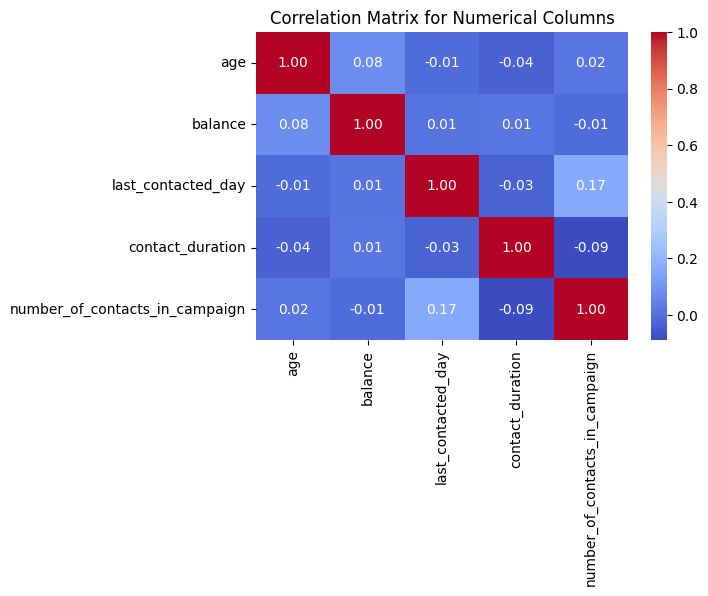

In [10]:
# Selecting only the numerical columns for correlation plot
numerical_cols = df.select_dtypes(include=['int64', 'float64'])

# Plotting the correlation matrix
plt.figure(figsize=(6, 4))
sns.heatmap(numerical_cols.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix for Numerical Columns')
plt.show()

No correlations between any numerial columns such as their age & average yearly balance or contact duration and and number of contacts, there is a slight negative correlation which demonstrates that with the duration of contact reduces after each contact which makes logical sense as there are less queries and information being provided in subsequent calls & more being like follow-ups

Text(0.5, 1.0, 'Client Subscribed vs Not Subscribed by Job Type')

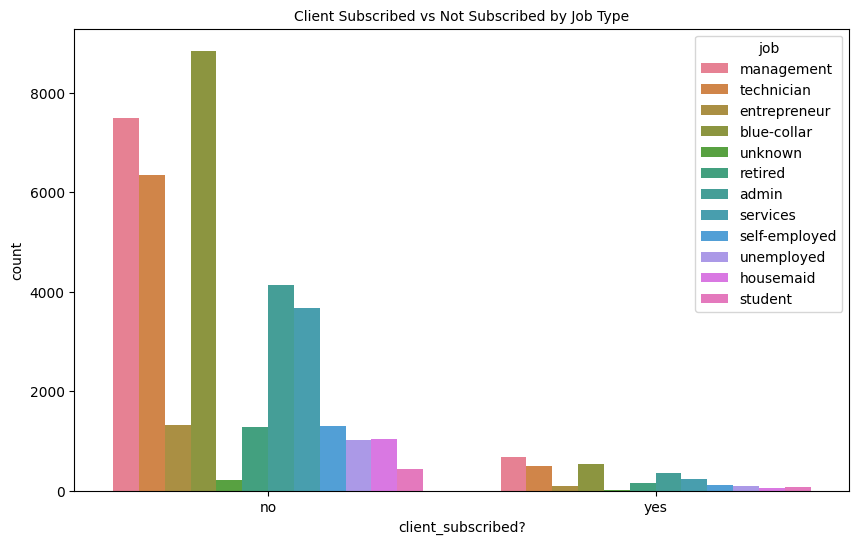

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='client_subscribed?', hue='job', data=df)
plt.title('Client Subscribed vs Not Subscribed by Job Type', fontsize=10)

Comments & Insights:

By focusing on the those clients that subscribed, we see that those in management level position, technicians, and those with blue-collar jobs make the highest percentage of subscribers.

These also make up the highest percentage of those who did not subscribe, but the blue collar jobs make up the highest who did not subscribe but not the highest in the category of subscribers.

But based on the numbers, **management, techician and blue-collar** jobs make the highest percentage of subscribers. These should be go to without any ML and model training etc.

Text(0.5, 1.0, 'Client Subscribed vs Not Subscribed by Job Type')

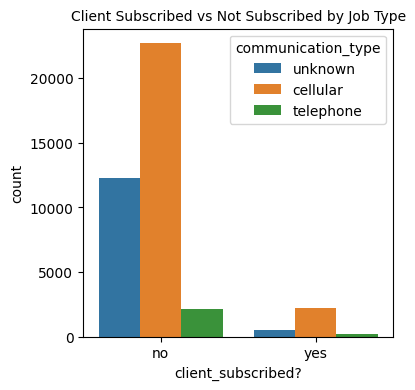

In [ ]:
plt.figure(figsize=(4, 4))
sns.countplot(x='client_subscribed?', hue='communication_type', data=df)
plt.title('Client Subscribed vs Not Subscribed by Job Type', fontsize=10)

Comments:



*   The dataset is fairly imblanaced for customers who subscribed & didn't
so to train a ML model would result in a biased model, hence we require utliizing under or oversampling techniques e.g., SMOTE, ADASYN etc.



Text(0.5, 1.0, 'Client Subscribed vs Not Subscribed by Job Type')

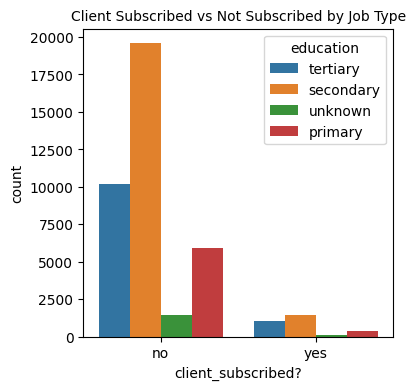

In [ ]:
plt.figure(figsize=(4, 4))
sns.countplot(x='client_subscribed?', hue='education', data=df)
plt.title('Client Subscribed vs Not Subscribed by Job Type', fontsize=10)

This suggests that those with tertiary & secondary education levels outnumber other categories that have subscribed so would be our key focus, secondary would most probably be technicians which we saw earlier making a high percentage of those who subscribed due to stable income.

In [ ]:
# Filter for people with secondary education
secondary_education_df = df[df['education'] == 'secondary']

# Group by job and count the occurrences, then find the job with the highest count
majority_job = secondary_education_df['job'].value_counts()

print(majority_job)

job
blue-collar      5144
technician       4788
admin            3723
services         3269
management       1037
retired           664
unemployed        622
self-employed     552
entrepreneur      507
housemaid         345
student           282
unknown            60
Name: count, dtype: int64


Indeed we see technicians do make a large percentage of those who have secondary education!

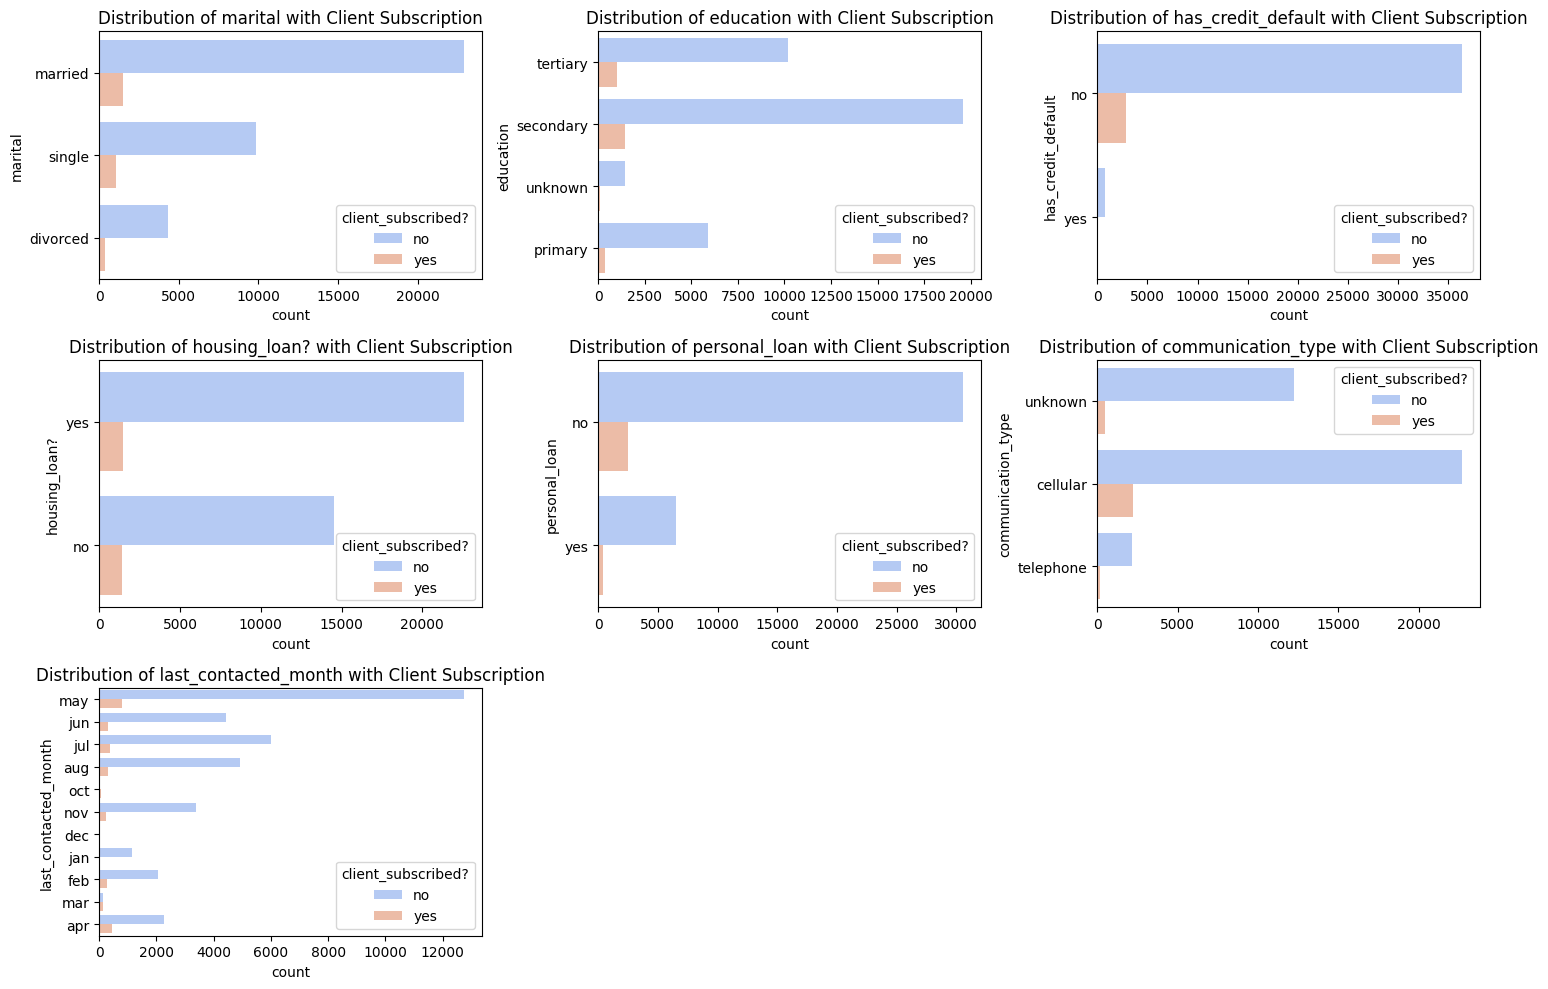

In [ ]:
# Selecting only the numerical columns for correlation plot
categorical_cols = df.select_dtypes(include=['object'])
categorical_cols = categorical_cols.drop(columns=['job', 'client_subscribed?'])  # Exclude 'job' column

# Plotting the distribution of the categorical columns using bar charts
plt.figure(figsize=(15, 10))

# Loop through each categorical column and create bar charts
for i, column in enumerate(categorical_cols.columns, 1):
    plt.subplot(3, 3, i)
    sns.countplot(y=df[column], hue=df['client_subscribed?'], palette='coolwarm')
    plt.title(f'Distribution of {column} with Client Subscription')
    plt.tight_layout()

plt.show()

Comments & Insights:



1.   Those who do not have previous personal loans make a higher percentage of those who have subscribed, hence targeting these would be the way to go.
2.   Those customers who have not defaulted previously on their credits or loans before make a higher percentage / share of those who have subsribed to term deposits (~ 2500) (red category) so these could be the ones to target for calling. **These will be more likely to subscribe than people who have  defaulted before and perhaps cannot afford this or do not want to risk again defaulting on their credits.**
3.   In the month of May, it seems it has generated the most amount of subscribers which could be due to some seasonality of prices or other external factors but an interesting find, this could be due to lower interest rates during that month or summer promotions etc.
4.   The most effective method of contacting based on the data above is through cellular or mobile phones, so best to avoid landline numbers etc. Unknown could have included methods like email or in-person events but unfortunately there is no way of knowing this.



### 1st Layer: Pre-Campaign Customer Selection (Classification)

Feature Engineering / Train-Test Split



*   Firstly, since we are not using campaign related data, we require dropping the campaign related data, so we will drop the following columns from our data for training our first ML model:
          1. communication_type
          2. last_contacted_day  
          3. last_contacted_month
          4. contact_duration   
          5. number_of_contacts_in_campaign  
*    Then, we will perform One-hot-Encoding to convert categorial data into numerial format as ML models require numerical inputs & we will set drop_first as true to avoid multi-collinearity.
*    Lastly, we will split the data into train & test and use LazyClassifier to pick the best initial performing model for this random seed.



In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   age                             40000 non-null  int64 
 1   job                             40000 non-null  object
 2   marital                         40000 non-null  object
 3   education                       40000 non-null  object
 4   has_credit_default              40000 non-null  object
 5   balance                         40000 non-null  int64 
 6   housing_loan?                   40000 non-null  object
 7   personal_loan                   40000 non-null  object
 8   communication_type              40000 non-null  object
 9   last_contacted_day              40000 non-null  int64 
 10  last_contacted_month            40000 non-null  object
 11  contact_duration                40000 non-null  int64 
 12  number_of_contacts_in_campaign  40000 non-null

In [ ]:
first_layer_df = df.drop(columns=['communication_type', 'last_contacted_day', 'last_contacted_month', 'contact_duration', 'number_of_contacts_in_campaign'])
first_layer_df_encoded = pd.get_dummies(first_layer_df, columns=['has_credit_default', 'job', 'marital', 'education', 'housing_loan?', 'personal_loan'], drop_first=True)  # drop_first removes one category to avoid multicollinearity


In [ ]:
first_layer_df_encoded.head()

,age,balance,client_subscribed?,has_credit_default_yes,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,...,job_technician,job_unemployed,job_unknown,marital_married,marital_single,education_secondary,education_tertiary,education_unknown,housing_loan?_yes,personal_loan_yes
0,58,2143,no,False,False,False,False,True,False,False,...,False,False,False,True,False,False,True,False,True,False
1,44,29,no,False,False,False,False,False,False,False,...,True,False,False,False,True,True,False,False,True,False
2,33,2,no,False,False,True,False,False,False,False,...,False,False,False,True,False,True,False,False,True,True
3,47,1506,no,False,True,False,False,False,False,False,...,False,False,False,True,False,False,False,True,True,False
4,33,1,no,False,False,False,False,False,False,False,...,False,False,True,False,True,False,False,True,False,False


In [ ]:
# Split X and y
X = first_layer_df_encoded.drop(columns=['client_subscribed?'])
y = first_layer_df_encoded['client_subscribed?']


# Split the data into training and testing sets BEFORE applying SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=random_seed)


# Apply SMOTE only to the training data
smote = SMOTE(random_state=random_seed)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Check the class distribution after applying SMOTE
print("Class distribution in training set after balancing:")
print(y_train_balanced.value_counts())


# How SMOTE (Synthetic Minority Over-sampling) works?
# Identify Minority class, find nearest neigbors, create new synthetic sample
# through interpolation between data point and nearest neighbor through averaging
# their features values.

Class distribution in training set after balancing:
client_subscribed?
yes    27821
no     27821
Name: count, dtype: int64


In [ ]:
# Check the class distribution after applying SMOTE
print("Class distribution in training set after balancing:")
print(y_test.value_counts())

Class distribution in training set after balancing:
client_subscribed?
no     9283
yes     717
Name: count, dtype: int64


In [ ]:
# Select a random subset (e.g., 10% of the balanced training data) for faster model exploration
subset_percentage = 0.1
X_train_subset, y_train_subset = X_train_balanced.sample(frac=subset_percentage, random_state=random_seed), y_train_balanced.sample(frac=subset_percentage, random_state=random_seed)

In [ ]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_subset)
X_test_scaled = scaler.transform(X_test)

# Use LazyPredict for initial model exploration
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None, random_state=random_seed) # For getting quick overivew of a range of models on the dataset for justification
models, predictions = clf.fit(X_train_scaled, X_test_scaled, y_train_subset, y_test)


print("LazyPredict Model Performance:")
print(models)

 87%|████████▋ | 27/31 [00:51<00:05,  1.43s/it]

[LightGBM] [Info] Number of positive: 2741, number of negative: 2823
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001444 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 363
[LightGBM] [Info] Number of data points in the train set: 5564, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.492631 -> initscore=-0.029477
[LightGBM] [Info] Start training from score -0.029477


100%|██████████| 31/31 [00:51<00:00,  1.67s/it]

LazyPredict Model Performance:
                               Accuracy  Balanced Accuracy ROC AUC  F1 Score  \
Model                                                                          
BernoulliNB                        0.80               0.55    None      0.83   
NearestCentroid                    0.78               0.54    None      0.82   
BaggingClassifier                  0.83               0.54    None      0.85   
PassiveAggressiveClassifier        0.78               0.54    None      0.82   
RandomForestClassifier             0.83               0.54    None      0.85   
LGBMClassifier                     0.86               0.53    None      0.86   
DecisionTreeClassifier             0.76               0.53    None      0.81   
LabelSpreading                     0.81               0.53    None      0.84   
LabelPropagation                   0.81               0.53    None      0.84   
AdaBoostClassifier                 0.82               0.52    None      0.85   
KNeighbor

Model Selection: We will select LGBM Classifier as it performs the best on the subset of data in terms of F1-score. Below is the implementation of the model using the full dataset after utilizing oversampling techniques.

In [ ]:
# Function to train and evaluate a model
def train_and_evaluate(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy, model


# Split the data into training and testing sets BEFORE applying SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=random_seed)

# Apply SMOTE only to the training data
smote = SMOTE(random_state=random_seed)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)


# Import necessary libraries
from lightgbm import LGBMClassifier
# LGBM Classifier
lgbm_model = LGBMClassifier(random_state=random_seed, verbose=-1)
lgbm_accuracy, lgbm_model = train_and_evaluate(lgbm_model, X_train_scaled, X_test_scaled, y_train_balanced, y_test)
print(f"LGBM Classifier Accuracy: {lgbm_accuracy:.4f}")
# Print classification report for more detailed performance analysis
print("\nClassification Report:")# Predict on the test set
y_pred = lgbm_model.predict(X_test_scaled)
print(classification_report(y_test, y_pred, target_names=['Not Subscribed', 'Subscribed']))


LGBM Classifier Accuracy: 0.8661

Classification Report:
                precision    recall  f1-score   support

Not Subscribed       0.93      0.92      0.93      9283
    Subscribed       0.12      0.14      0.13       717

      accuracy                           0.87     10000
     macro avg       0.53      0.53      0.53     10000
  weighted avg       0.87      0.87      0.87     10000



The recall for Class 1 is extremely poor, so the model performs poorly at identifying customers who will subscribe than customers who will not subscribe. This is expected due to the severe class imbalance in our dataset, we require further hyperamareter tuning techniques to enhance its performance as our goal is for the model to be competent in predicting customers who will subscribe accurately so we can identify who to call and who to filter out. Additionally, I will try undersampling the data to see if we can get better performance for class 1.

In [ ]:
from imblearn.under_sampling import RandomUnderSampler


# Split the data into training and testing sets BEFORE applying SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_seed)

# Initialize the RandomUnderSampler
rus = RandomUnderSampler(random_state=random_seed) # This will make the majority class 1.5 times the minority class
# Fit and resample the training data
X_train_balanced, y_train_balanced = rus.fit_resample(X_train, y_train)
print(y_train_balanced.value_counts())

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)


# Import necessary libraries
from lightgbm import LGBMClassifier
# LGBM Classifier
lgbm_model = LGBMClassifier(random_state=random_seed, verbose=-1)
lgbm_accuracy, lgbm_model = train_and_evaluate(lgbm_model, X_train_scaled, X_test_scaled, y_train_balanced, y_test)
print(f"LGBM Classifier Accuracy: {lgbm_accuracy:.4f}")
# Print classification report for more detailed performance analysis
print("\nClassification Report:")# Predict on the test set
y_pred = lgbm_model.predict(X_test_scaled)
print(classification_report(y_test, y_pred, target_names=['Not Subscribed', 'Subscribed']))


client_subscribed?
no     2046
yes    2046
Name: count, dtype: int64
LGBM Classifier Accuracy: 0.5873

Classification Report:
                precision    recall  f1-score   support

Not Subscribed       0.94      0.59      0.73     11150
    Subscribed       0.09      0.52      0.15       850

      accuracy                           0.59     12000
     macro avg       0.51      0.55      0.44     12000
  weighted avg       0.88      0.59      0.69     12000



Now the recall for the Class 1 is significantly better however it is nowhere near our target of above 81%. There is another method to enhance recall score for class 1 where the class_weight paramter for the LightGBM can be manually adjusted, we can set a high weight for class 1 to force the model to focus more on the minority class. The default for class_weight is 'balanced' which calculates weight for each class based on its frequencey in the training data.

In [ ]:
# Split data into training and test sets before applying SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=random_seed)


# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Example: Assuming class 0 (Not Subscribed) has more samples than class 1 (Subscribed)
class_weights = {'no': 1, 'yes': 35}  # Higher weight for class 1 (Subscribed)
# Adjusting class weights for LightGBM (automatically handles class imbalance)
lgbm_model_weighted = LGBMClassifier(random_state=42, class_weight=class_weights, verbose=-1)

# Train the model and evaluate performance
lgbm_accuracy_weighted, lgbm_model_weighted = train_and_evaluate(lgbm_model_weighted, X_train_scaled, X_test_scaled, y_train, y_test)

# Predict on the test set with class weighting applied
y_pred_weighted = lgbm_model_weighted.predict(X_test_scaled)

# Print classification report for the weighted model
print(f"LGBM Classifier Accuracy with Class Weights: {lgbm_accuracy_weighted:.4f}")
print("\nClassification Report (with class weights):")
print(classification_report(y_test, y_pred_weighted, target_names=['Not Subscribed', 'Subscribed']))


LGBM Classifier Accuracy with Class Weights: 0.2944

Classification Report (with class weights):
                precision    recall  f1-score   support

Not Subscribed       0.95      0.25      0.40      9283
    Subscribed       0.08      0.83      0.14       717

      accuracy                           0.29     10000
     macro avg       0.51      0.54      0.27     10000
  weighted avg       0.89      0.29      0.38     10000



Now we observe better results for recall for Class 1 as desired but it has greatly reduced the overall accuracy of our model but the accuracy is still relatively poor.


We require alternative oversampling methods since in the real-world, we cannot convince majority of customers so this technique will help us mimic that instead of oversampling using SMOTE only, meaning that the oversampled data points might not accurately reflect real-word scenrios. THis is where SMOTE Tomek can help us as it removes noisy examples from the majority class and oversamples the minority class with very similar examples leading to a cleaner & realistic dataset.

We will use Smote Tomek & Smote ENN and select the one which gives us the best result.


### Smote Tomek:

This hybrid technique combines SMOTE (Synthetic Minority Over-Sampling) & Tomek Links. Tomek links are used to clean the dataset by undersampling the majority class. This is used to identify pairs in the dataset which are really similar or identicial and removes the instances from the majority class. With this combination, there is both an increase in the instances of the minority classes & lesser overlap between the data in the majority class.



In [ ]:
from imblearn.combine import SMOTETomek


# Split the data into training and testing sets BEFORE applying SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_seed)

# Initialize SMOTE Tomek
smote_tomek = SMOTETomek(random_state=random_seed)
# Fit and resample the training data
X_train_balanced, y_train_balanced = smote_tomek.fit_resample(X_train, y_train)

# Check the class distribution after resampling
print(y_train_balanced.value_counts())

client_subscribed?
no     24611
yes    24611
Name: count, dtype: int64


### With Scaling

In [ ]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)


In [ ]:
# LGBM Classifier
class_weights = {'no': 1, 'yes': 1}  # Higher weight for class 1 (Subscribed)

lgbm_model = LGBMClassifier(random_state=random_seed, class_weight=class_weights, verbose=-1)

# lgbm_model = LGBMClassifier(random_state=random_seed, verbose=-1)
lgbm_accuracy, lgbm_model = train_and_evaluate(lgbm_model, X_train_scaled, X_test_scaled, y_train_balanced, y_test)

print(f"LGBM Classifier Accuracy: {lgbm_accuracy:.4f}")

# Predict on the test set
y_pred = lgbm_model.predict(X_test_scaled)

# Print classification report for more detailed performance analysis
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Not Subscribed', 'Subscribed']))

LGBM Classifier Accuracy: 0.8703

Classification Report:
                precision    recall  f1-score   support

Not Subscribed       0.93      0.93      0.93     11150
    Subscribed       0.13      0.15      0.14       850

      accuracy                           0.87     12000
     macro avg       0.53      0.54      0.53     12000
  weighted avg       0.88      0.87      0.87     12000



### Without Scaling

In [ ]:
# LGBM Classifier
class_weights = {'no': 1, 'yes': 1}  # Higher weight for class 1 (Subscribed)

lgbm_model = LGBMClassifier(random_state=random_seed, class_weight=class_weights, verbose=-1)

# lgbm_model = LGBMClassifier(random_state=random_seed, verbose=-1)
lgbm_accuracy, lgbm_model = train_and_evaluate(lgbm_model, X_train_balanced, X_test, y_train_balanced, y_test)

print(f"LGBM Classifier Accuracy: {lgbm_accuracy:.4f}")

# Predict on the test set
y_pred = lgbm_model.predict(X_test)

# Print classification report for more detailed performance analysis
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Not Subscribed', 'Subscribed']))

LGBM Classifier Accuracy: 0.8712

Classification Report:
                precision    recall  f1-score   support

Not Subscribed       0.93      0.93      0.93     11150
    Subscribed       0.13      0.14      0.14       850

      accuracy                           0.87     12000
     macro avg       0.53      0.54      0.53     12000
  weighted avg       0.88      0.87      0.87     12000



It seems removing scaling does not make much difference to the model performance for LGBM classifier. Let's explore another oveesmapling technique Smote ENN to see if we get better results.

### Smote ENN

SMOTE ENN (Synthetic Minority Over-sampling Technique with Edited Nearest Neighbors) is another hybrid resampling method. It will combine SMOTE for oversampling and using Edted Nearest Neighbours (ENN) for undersampling the majority class. ENN works by removing the instances with different class labels within typically a range of k=3, if those labels have different labels, those data points will be removed from our dataset.

In [ ]:
# Import necessary libraries
from imblearn.combine import SMOTEENN
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_seed)

# Initialize SMOTE ENN
smote_enn = SMOTEENN(random_state=random_seed)

# Fit and resample the training data
X_train_balanced_enn, y_train_balanced_enn = smote_enn.fit_resample(X_train, y_train)

# Check the class distribution after resampling
print(y_train_balanced.value_counts())

client_subscribed?
no     24611
yes    24611
Name: count, dtype: int64


### With Scaling

In [ ]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced_enn)
X_test_scaled = scaler.transform(X_test)

# LGBM Classifier
lgbm_model = LGBMClassifier(random_state=random_seed, verbose=-1)
lgbm_accuracy, lgbm_model = train_and_evaluate(lgbm_model, X_train_scaled, X_test_scaled, y_train_balanced_enn, y_test)

print(f"LGBM Classifier Accuracy: {lgbm_accuracy:.4f}")

# Predict on the test set
y_pred = lgbm_model.predict(X_test_scaled)

# Print classification report for more detailed performance analysis
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Not Subscribed', 'Subscribed']))


LGBM Classifier Accuracy: 0.8194

Classification Report:
                precision    recall  f1-score   support

Not Subscribed       0.94      0.86      0.90     11150
    Subscribed       0.11      0.23      0.15       850

      accuracy                           0.82     12000
     macro avg       0.53      0.55      0.53     12000
  weighted avg       0.88      0.82      0.85     12000



### Without Scaling

In [ ]:
# LGBM Classifier
lgbm_model = LGBMClassifier(random_state=random_seed, verbose=-1)
lgbm_accuracy, lgbm_model = train_and_evaluate(lgbm_model, X_train_balanced_enn, X_test, y_train_balanced_enn, y_test)

print(f"LGBM Classifier Accuracy: {lgbm_accuracy:.4f}")

# Predict on the test set
y_pred = lgbm_model.predict(X_test)

# Print classification report for more detailed performance analysis
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Not Subscribed', 'Subscribed']))


LGBM Classifier Accuracy: 0.8224

Classification Report:
                precision    recall  f1-score   support

Not Subscribed       0.94      0.87      0.90     11150
    Subscribed       0.12      0.23      0.16       850

      accuracy                           0.82     12000
     macro avg       0.53      0.55      0.53     12000
  weighted avg       0.88      0.82      0.85     12000



So far, with SMOTE ENN & SMOTE Tomek, the results have been more or less the same with regards to both classes even when using different class weights for LGBM Classifier. What we do see is that with Smote ENN, we get better results for the subscribed class or Class 1 (23% recall), hence from now, we will continue with that approach


The next stage is to perform hyperparameter tuning using hyperopt for the LGB model, we will select the new training dataset with SMOTE ENN as an example to inspect whether our results for the subscribed class greatly improves or not along with a high accuracy score (>81% required).

Without scaling does lead to better performance, we will also explore with Min-Max Scaling to see whether that offers superior results.

## Min-Max Scaling

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Scale the features using MinMaxScaler
X_train_scaled = scaler.fit_transform(X_train_balanced_enn)
X_test_scaled = scaler.transform(X_test)

# Initialize the LGBM Classifier
lgbm_model = LGBMClassifier(random_state=random_seed, verbose=-1)

# Train and evaluate the LGBM Classifier (assuming train_and_evaluate is a custom function)
lgbm_accuracy, lgbm_model = train_and_evaluate(lgbm_model, X_train_scaled, X_test_scaled, y_train_balanced_enn, y_test)

print(f"LGBM Classifier Accuracy: {lgbm_accuracy:.4f}")

# Predict on the test set
y_pred = lgbm_model.predict(X_test_scaled)

# Print classification report for more detailed performance analysis
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Not Subscribed', 'Subscribed']))

LGBM Classifier Accuracy: 0.8201

Classification Report:
                precision    recall  f1-score   support

Not Subscribed       0.94      0.86      0.90     11150
    Subscribed       0.12      0.23      0.15       850

      accuracy                           0.82     12000
     macro avg       0.53      0.55      0.53     12000
  weighted avg       0.88      0.82      0.85     12000



Same results so we will choose to go with the non-scaled option for tackling layer 1 problem.

### Hyperparameter tuning

5-Fold Cross Validation:

Splitting the data into 5 Folds, each fold will contain roughly the same proportion of data. The model is trained & tested 5 times, in each iteration, 4 folds are used for training and the remaining for testing or validation. After 5 iterations, the performance scores from each iteration are averaged.

Our hyperparameter tuning will focus on accuracy where afterwards we will change the weights to get the best recall for class 1. We will tune on without scaled dataset as that gave us the best score till now for LGBM classifier.

We will do 50 evaluations focused on accuracy, so we ensure high accuracy at the start and then after changing the weights, favor class 1.


In [ ]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import recall_score, make_scorer


# Define a search space for hyperparameters
search_space = {
    'num_leaves': hp.choice('num_leaves', [20, 100]),  # 3 values
    'learning_rate': hp.uniform('learning_rate', 0.001, 0.5),  # Slightly vast range
    'max_depth': hp.choice('max_depth', [3, 5 ,8, 11]),  # 3 values
    'n_estimators': hp.choice('n_estimators', [100]),  # 3 values
    'min_child_samples': hp.choice('min_child_samples', [30]),  # 3 values
    'subsample': hp.uniform('subsample', 0.7, 0.9),  # Narrowed range for subsampling
    'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 0.9),  # Narrowed range for column sampling
    'class_weight': hp.choice('class_weight', ['balanced', None]),  # No change here
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 0.9),  # regularization
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 0.9),  # regularization
}


# Define 5-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_seed)

# Objective function for HyperOpt
def objective(params):
    # Initialize LGBMClassifier with the current set of hyperparameters
    lgbm_model = LGBMClassifier(random_state=random_seed, **params)

    # Perform 5-fold cross-validation and return the average accuracy score
    accuracy = cross_val_score(lgbm_model, X_train_balanced_enn, y_train_balanced_enn, cv=cv, scoring='accuracy').mean()

    # HyperOpt minimizes the objective function, so we return the negative accuracy
    return {'loss': -accuracy, 'status': STATUS_OK}

# Run HyperOpt optimization with 5-fold cross-validation
trials = Trials()
best_params = fmin(fn=objective,
                   space=search_space,
                   algo=tpe.suggest,
                   max_evals=50,  # Number of evaluations
                   trials=trials,
                   rstate=np.random.default_rng(random_seed))

# Print the best parameters
print("Best Hyperparameters:", best_params)

100%|██████████| 50/50 [01:45<00:00,  2.12s/trial, best loss: -0.9433930451104869]
Best Hyperparameters: {'class_weight': 1, 'colsample_bytree': 0.7330559403363128, 'learning_rate': 0.44666388656503264, 'max_depth': 3, 'min_child_samples': 0, 'n_estimators': 0, 'num_leaves': 1, 'reg_alpha': 0.0954585958631623, 'reg_lambda': 0.22366597669931457, 'subsample': 0.7397223289775753}


In [ ]:
# Print the best parameters
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'class_weight': 1, 'colsample_bytree': 0.7330559403363128, 'learning_rate': 0.44666388656503264, 'max_depth': 3, 'min_child_samples': 0, 'n_estimators': 0, 'num_leaves': 1, 'reg_alpha': 0.0954585958631623, 'reg_lambda': 0.22366597669931457, 'subsample': 0.7397223289775753}


In [ ]:
# LGBM Classifier

# Map the values from best_params into the proper ranges for certain hyperparameters
best_lgbm_model = LGBMClassifier(
    num_leaves=[20, 100][int(best_params['num_leaves'])],  # Correct handling of choice
    learning_rate=best_params['learning_rate'],
    max_depth=[3, 5, 8, 11][int(best_params['max_depth'])],  # Correct handling of choice
    n_estimators=[100][int(best_params['n_estimators'])],  # Since only 100 was defined in the space
    min_child_samples=[30][int(best_params['min_child_samples'])],  # Since only 30 was defined in the space
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    class_weight='balanced' if best_params['class_weight'] > 0 else None,  # Correct class_weight handling
    reg_alpha=best_params['reg_alpha'],
    reg_lambda=best_params['reg_lambda'],
    random_state=random_seed
)

# Perform 5-fold cross-validation on the best model
cv_scores = cross_val_score(best_lgbm_model, X_train_balanced_enn, y_train_balanced_enn, cv=cv, scoring='accuracy')

# Print average accuracy across the 5 folds
print(f"Average Accuracy across 5 folds: {cv_scores.mean():.4f}")




# Train on the entire training data and evaluate on test data
best_lgbm_model.fit(X_train_balanced_enn, y_train_balanced_enn)
y_pred = best_lgbm_model.predict(X_test)

# Calculate and print the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")

# Print the classification report on the test set
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_pred, target_names=['Not Subscribed', 'Subscribed']))


Average Accuracy across 5 folds: 0.9426

Accuracy: 0.8281

Classification Report on Test Set:
                precision    recall  f1-score   support

Not Subscribed       0.94      0.88      0.90     11150
    Subscribed       0.11      0.21      0.15       850

      accuracy                           0.83     12000
     macro avg       0.52      0.54      0.53     12000
  weighted avg       0.88      0.83      0.85     12000



No much improvement in recall, actually it decreased. Let us change the class weights somewhat to favour the subscribed more and see if we can get a reasonable recall score for class 1. If we can maintain reasonable accuracy and reach a recall score above 60% for class 1, that would be great progress!

In [ ]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import recall_score
from lightgbm import LGBMClassifier

# Define a search space for hyperparameters
search_space = {
    'num_leaves': hp.choice('num_leaves', [20, 100]),  # Number of leaves
    'learning_rate': hp.uniform('learning_rate', 0.001, 0.5),  # Learning rate
    'max_depth': hp.choice('max_depth', [3, 5, 8, 11]),  # Maximum depth
    'n_estimators': hp.choice('n_estimators', [100, 300, 500]),  # Number of estimators (boosting rounds)
    'min_child_samples': hp.choice('min_child_samples', [20, 30, 40]),  # Minimum child samples
    'subsample': hp.uniform('subsample', 0.7, 0.9),  # Subsampling
    'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 0.9),  # Column sampling
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 0.9),  # L1 regularization
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 0.9),  # L2 regularization
    'max_bin': hp.choice('max_bin', [50, 100, 200, 300]),  # Maximum number of bins for discretization
    'num_boost_round': hp.choice('num_boost_round', [50, 100, 200, 300])  # Number of boosting rounds
}

# Define 5-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_seed)

# Objective function for HyperOpt
def objective(params):
    # Initialize LGBMClassifier with the current set of hyperparameters
    lgbm_model = LGBMClassifier(
        random_state=random_seed,
        num_leaves=params['num_leaves'],
        learning_rate=params['learning_rate'],
        max_depth=params['max_depth'],
        n_estimators=params['n_estimators'],
        min_child_samples=params['min_child_samples'],
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        reg_alpha=params['reg_alpha'],
        reg_lambda=params['reg_lambda'],
        max_bin=params['max_bin']
    )

    # Perform 5-fold cross-validation and return the average accuracy score
    accuracy = cross_val_score(lgbm_model, X_train_balanced_enn, y_train_balanced_enn, cv=cv, scoring='accuracy').mean()

    # HyperOpt minimizes the objective function, so we return the negative accuracy
    return {'loss': -accuracy, 'status': STATUS_OK}

# Run HyperOpt optimization with 5-fold cross-validation
trials = Trials()
best_params = fmin(fn=objective,
                   space=search_space,
                   algo=tpe.suggest,
                   max_evals=50,  # Number of evaluations
                   trials=trials,
                   rstate=np.random.default_rng(random_seed))

# Print the best parameters
print("Best Hyperparameters:", best_params)


100%|██████████| 50/50 [05:09<00:00,  6.20s/trial, best loss: -0.9492961556371906]
Best Hyperparameters: {'colsample_bytree': 0.6794570739176222, 'learning_rate': 0.3376277546263712, 'max_bin': 3, 'max_depth': 2, 'min_child_samples': 0, 'n_estimators': 2, 'num_boost_round': 0, 'num_leaves': 1, 'reg_alpha': 0.252815085665436, 'reg_lambda': 0.3689115728765139, 'subsample': 0.8322556853480513}


In [ ]:
best_params =  {'colsample_bytree': 0.6794570739176222, 'learning_rate': 0.3376277546263712, 'max_bin': 3, 'max_depth': 2, 'min_child_samples': 0, 'n_estimators': 2, 'num_boost_round': 0, 'num_leaves': 1, 'reg_alpha': 0.252815085665436, 'reg_lambda': 0.3689115728765139, 'subsample': 0.8322556853480513}

# Map the values from best_params into the proper ranges for certain hyperparameters
best_lgbm_model = LGBMClassifier(
    num_leaves=[20, 100][int(best_params['num_leaves'])],  # Correct handling of choice
    learning_rate=best_params['learning_rate'],
    max_depth=[3, 5, 8, 11][int(best_params['max_depth'])],  # Correct handling of choice
    n_estimators=[100, 300, 500][int(best_params['n_estimators'])],  # Since only 100 was defined in the space
    min_child_samples=[30][int(best_params['min_child_samples'])],  # Since only 30 was defined in the space
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    reg_alpha=best_params['reg_alpha'],
    reg_lambda=best_params['reg_lambda'],
    max_bin=[50, 100, 200, 300][best_params['max_bin']],
    num_boost_round=[50, 100, 200, 300][best_params['num_boost_round']],
    random_state=random_seed
)



# Perform 5-fold cross-validation on the best model
cv_scores = cross_val_score(best_lgbm_model, X_train_balanced_enn, y_train_balanced_enn, cv=5, scoring='accuracy')

# Print average accuracy across the 5 folds
print(f"Average Accuracy across 5 folds: {cv_scores.mean():.4f}")

# Train on the entire training data and evaluate on test data
best_lgbm_model.fit(X_train_balanced_enn, y_train_balanced_enn)
y_pred = best_lgbm_model.predict(X_test)


# Calculate and print the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")

# Print the classification report on the test set
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_pred, target_names=['Not Subscribed', 'Subscribed']))

Average Accuracy across 5 folds: 0.9188

Accuracy: 0.8163

Classification Report on Test Set:
                precision    recall  f1-score   support

Not Subscribed       0.94      0.86      0.90     11150
    Subscribed       0.11      0.22      0.15       850

      accuracy                           0.82     12000
     macro avg       0.52      0.54      0.52     12000
  weighted avg       0.88      0.82      0.84     12000



In [ ]:
# LGBM Classifier
class_weights = {'no': 1, 'yes': 25}

# Map the values from best_params into the proper ranges for certain hyperparameters
best_lgbm_model = LGBMClassifier(
    num_leaves=[20, 100][int(best_params['num_leaves'])],  # Correct handling of choice
    learning_rate=best_params['learning_rate'],
    max_depth=[3, 5, 8, 11][int(best_params['max_depth'])],  # Correct handling of choice
    n_estimators=[100, 300, 500][int(best_params['n_estimators'])],  # Since only 100 was defined in the space
    min_child_samples=[30][int(best_params['min_child_samples'])],  # Since only 30 was defined in the space
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    class_weight=class_weights,  # Correct class_weight handling
    reg_alpha=best_params['reg_alpha'],
    reg_lambda=best_params['reg_lambda'],
    max_bin=[50, 100, 200, 300][best_params['max_bin']],
    num_boost_round=[50, 100, 200, 300][best_params['num_boost_round']],
    random_state=random_seed
)


# Perform 5-fold cross-validation on the best model
cv_scores = cross_val_score(best_lgbm_model, X_train_balanced_enn, y_train_balanced_enn, cv=5, scoring='accuracy')

# Print average accuracy across the 5 folds
print(f"Average Accuracy across 5 folds: {cv_scores.mean():.4f}")

# Train on the entire training data and evaluate on test data
best_lgbm_model.fit(X_train_balanced_enn, y_train_balanced_enn)
y_pred = best_lgbm_model.predict(X_test)


# Calculate and print the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")

# Print the classification report on the test set
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_pred, target_names=['Not Subscribed', 'Subscribed']))


Average Accuracy across 5 folds: 0.8203

Accuracy: 0.4940

Classification Report on Test Set:
                precision    recall  f1-score   support

Not Subscribed       0.94      0.48      0.64     11150
    Subscribed       0.09      0.63      0.15       850

      accuracy                           0.49     12000
     macro avg       0.52      0.56      0.39     12000
  weighted avg       0.88      0.49      0.61     12000



It seems our model cannot maintain both high accuracy and recall for class 1 at the same time. What we aim for is accuracy above 70% and recall with a high score as well. So this was an** unsuccessful** model overall.

Let us experiment with more models, particularly SGD classifier & Bernoulli NB to see and experiment if we can achieve slighly better results. If we have above 70% accuracy and above 80% recall score for class 1, that would be the ideal scenario.

***We do not know the exact ratio when it comes to altering the model weights but this yields promising results as shown above (process similar to regularization).***


Let us first experiment with knn, bagging & lightGBM classifiers using stacking and voting to see if we get any promising results

In [ ]:
# Import necessary libraries
from sklearn.ensemble import BaggingClassifier, VotingClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score

# Function to train and evaluate a model
def train_and_evaluate(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(classification_report(y_test, y_pred, target_names=['Not Subscribed', 'Subscribed']))
    return accuracy, model

# Bagging Classifier with DecisionTree as base estimator
bagging_model = BaggingClassifier(estimator=DecisionTreeClassifier(random_state=random_seed),
                                  n_estimators=10, random_state=random_seed)

bagging_accuracy, bagging_model = train_and_evaluate(bagging_model, X_train_balanced_enn, X_test, y_train_balanced_enn, y_test)
print(f"Bagging Classifier Accuracy: {bagging_accuracy:.4f}")

# K-Nearest Neighbors Classifier (KNeighbors)
knn_model = KNeighborsClassifier(n_neighbors=5)  # Use default 5 neighbors
knn_accuracy, knn_model = train_and_evaluate(knn_model, X_train_balanced_enn, X_test, y_train_balanced_enn, y_test)
print(f"K-Nearest Neighbors Classifier Accuracy: {knn_accuracy:.4f}")

# LGBM Classifier
lgbm_model = LGBMClassifier(random_state=random_seed, verbose=-1)
lgbm_accuracy, lgbm_model = train_and_evaluate(lgbm_model, X_train_balanced_enn, X_test, y_train_balanced_enn, y_test)
print(f"LGBM Classifier Accuracy: {lgbm_accuracy:.4f}")

### Voting Classifier with soft voting
voting_model = VotingClassifier(
    estimators=[
        ('bagging', bagging_model),
        ('knn', knn_model),
        ('lgbm', lgbm_model)
    ],
    voting='soft',  # Use soft voting
    weights=[2, 3, 5]  # You can adjust weights based on performance of each model
)

voting_accuracy, voting_model = train_and_evaluate(voting_model, X_train_balanced_enn, X_test, y_train_balanced_enn, y_test)
print(f"Voting Classifier Accuracy: {voting_accuracy:.4f}")

### Stacking Classifier
# Define base models for stacking
base_models = [
    ('bagging', bagging_model),
    ('knn', knn_model),
    ('lgbm', lgbm_model)
]

# Define meta-model (final estimator)
meta_model = DecisionTreeClassifier(random_state=random_seed)

# Initialize StackingClassifier
stacking_model = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5  # Use cross-validation to generate meta-features
)

stacking_accuracy, stacking_model = train_and_evaluate(stacking_model, X_train_balanced_enn, X_test, y_train_balanced_enn, y_test)
print(f"Stacking Classifier Accuracy: {stacking_accuracy:.4f}")

# Compare models
models = {
    "Bagging Classifier": bagging_accuracy,
    "K-Nearest Neighbors Classifier": knn_accuracy,
    "LGBM Classifier": lgbm_accuracy,
    "Voting Classifier": voting_accuracy,
    "Stacking Classifier": stacking_accuracy
}

# Print the best model based on accuracy
best_model = max(models, key=models.get)
print(f"Best model: {best_model} with accuracy: {models[best_model]:.4f}")


                precision    recall  f1-score   support

Not Subscribed       0.94      0.88      0.91     11150
    Subscribed       0.11      0.20      0.14       850

      accuracy                           0.83     12000
     macro avg       0.52      0.54      0.53     12000
  weighted avg       0.88      0.83      0.85     12000

Bagging Classifier Accuracy: 0.8332
                precision    recall  f1-score   support

Not Subscribed       0.93      0.56      0.70     11150
    Subscribed       0.08      0.48      0.13       850

      accuracy                           0.55     12000
     macro avg       0.51      0.52      0.42     12000
  weighted avg       0.87      0.55      0.66     12000

K-Nearest Neighbors Classifier Accuracy: 0.5523
                precision    recall  f1-score   support

Not Subscribed       0.94      0.87      0.90     11150
    Subscribed       0.12      0.23      0.16       850

      accuracy                           0.82     12000
     macro a

In [ ]:
### Voting Classifier with soft voting
voting_model = VotingClassifier(
    estimators=[
        ('bagging', bagging_model),
        ('knn', knn_model),
        ('lgbm', lgbm_model)
    ],
    voting='soft',  # Use soft voting
    weights=[100, 50, 150]  # You can adjust weights based on performance of each model
)

voting_accuracy, voting_model = train_and_evaluate(voting_model, X_train_balanced_enn, X_test, y_train_balanced_enn, y_test)
print(f"Voting Classifier Accuracy: {voting_accuracy:.4f}")

### Stacking Classifier
# Define base models for stacking
base_models = [
    ('bagging', bagging_model),
    ('knn', knn_model),
    ('lgbm', lgbm_model)
]

                precision    recall  f1-score   support

Not Subscribed       0.94      0.87      0.90     11150
    Subscribed       0.11      0.21      0.15       850

      accuracy                           0.83     12000
     macro avg       0.53      0.54      0.53     12000
  weighted avg       0.88      0.83      0.85     12000

Voting Classifier Accuracy: 0.8279


Nothing really promising above for recall even using voting and stacking methods, let us explore with SGD and other models below

## SGD Classifier

Use SGD Classifier to see better performance for recall for Class 1 so we can identify as many subscribers as possible. Stochastic Gradient Descent is a linear model used for sparse datasets, SGD updates weights after processing each sample or mini-batch. Where LGBM builds multiple decision trees, SGD is a linear classifier and works best when the data has a linear decision. We will use the oversampled SMOTE ENN dataset without scaling.

In [ ]:
# Import necessary libraries
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, classification_report

# Reinitialize the model to ensure no prior weights are being used
sgd_model = SGDClassifier(random_state=random_seed)

# Fit the model on the training data
sgd_model.fit(X_train_balanced_enn, y_train_balanced_enn)

# Predict on the test set
y_pred = sgd_model.predict(X_test)

# Calculate and print the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")

# Print classification report for more detailed performance analysis
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Not Subscribed', 'Subscribed']))



Accuracy: 0.2302

Classification Report:
                precision    recall  f1-score   support

Not Subscribed       0.95      0.18      0.30     11150
    Subscribed       0.08      0.88      0.14       850

      accuracy                           0.23     12000
     macro avg       0.51      0.53      0.22     12000
  weighted avg       0.89      0.23      0.29     12000



We get really high recall score which is highly desired, the accuracy score is very low so it is worth performing hyperparameter tuning to see if we can boost this by a certain reasonable amount.

### Hyperparameter tuning for SGD & Results

In [ ]:
# Import necessary libraries for hyperparameter tuning
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import recall_score, make_scorer

# Define the hyperparameter space for SGDClassifier
search_space = {
    'alpha': hp.uniform('alpha', 0.0001, 0.1),  # Learning rate or regularization strength
    'loss': hp.choice('loss', ['hinge', 'log_loss', 'modified_huber', 'squared_hinge']),  # Loss function
    'penalty': hp.choice('penalty', ['l2', 'l1', 'elasticnet']),  # Regularization technique
    'l1_ratio': hp.uniform('l1_ratio', 0.0, 1.0)  # ElasticNet mixing ratio (only used if penalty='elasticnet')
}

# Define cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_seed)

# Create a custom scorer for recall on class 1
recall_scorer = make_scorer(recall_score, pos_label=1)

# Define the objective function for HyperOpt
def objective(params):
    # Initialize SGDClassifier with the current set of hyperparameters
    sgd_model = SGDClassifier(random_state=random_seed, **params)

    # Perform 5-fold cross-validation and calculate the mean recall for class 1
    recall = cross_val_score(sgd_model, X_train_balanced_enn, y_train_balanced_enn, cv=cv, scoring=recall_scorer).mean()

    # Additionally calculate accuracy to ensure we balance recall with decent accuracy
    accuracy = cross_val_score(sgd_model, X_train_balanced_enn, y_train_balanced_enn, cv=cv, scoring='accuracy').mean()

    # We aim to maximize recall while ensuring accuracy does not drop below a threshold (e.g., 0.7)
    # Return the negative recall because HyperOpt minimizes the loss
    if accuracy >= 0.8:  # Only consider recall if accuracy is good enough
        return {'loss': -recall, 'status': STATUS_OK}
    else:
        return {'loss': float('inf'), 'status': STATUS_OK}  # Penalize poor accuracy


# Run the hyperparameter optimization using HyperOpt
trials = Trials()
best_sgd_params = fmin(fn=objective,
                   space=search_space,
                   algo=tpe.suggest,
                   max_evals=60,  # Number of evaluations
                   trials=trials,
                   rstate=np.random.default_rng(random_seed))

# Map the best loss and penalty choices back to their respective string values
best_sgd_params['loss'] = ['hinge', 'log_loss', 'modified_huber', 'squared_hinge'][best_sgd_params['loss']]
best_sgd_params['penalty'] = ['l2', 'l1', 'elasticnet'][best_sgd_params['penalty']]


# Print the best parameters
print("Best Hyperparameters:", best_sgd_params)

# Reinitialize the SGDClassifier with the best hyperparameters
sgd_model = SGDClassifier(random_state=random_seed, **best_sgd_params)

# Train the model on the entire training data
sgd_model.fit(X_train_balanced_enn, y_train_balanced_enn)

# Predict on the test set
y_pred = sgd_model.predict(X_test)

# Perform 5-fold cross-validation on the best model
cv_scores = cross_val_score(sgd_model, X_train_balanced_enn, y_train_balanced_enn, cv=cv, scoring='accuracy')

# Print average accuracy across the 5 folds
print(f"Average Accuracy across 5 folds: {cv_scores.mean():.4f}")
# Calculate and print the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")
# Print classification report for more detailed performance analysis
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Not Subscribed', 'Subscribed']))


100%|██████████| 60/60 [04:44<00:00,  4.74s/trial, best loss: inf]
Best Hyperparameters: {'alpha': 0.0143673347460286, 'l1_ratio': 0.015878829825360485, 'loss': 'modified_huber', 'penalty': 'l1'}
Average Accuracy across 5 folds: 0.7852

Accuracy: 0.7412

Classification Report:
                precision    recall  f1-score   support

Not Subscribed       0.94      0.77      0.85     11150
    Subscribed       0.09      0.30      0.14       850

      accuracy                           0.74     12000
     macro avg       0.51      0.54      0.49     12000
  weighted avg       0.88      0.74      0.80     12000



We achieved higher accuracy and recall but as mentioned earlier, we are seeking a higher recall score, at least above 60%. Let us change the class weights to see if we can achieve that.

In [ ]:
# SGD  Classifier
class_weights = {'no': 1, 'yes': 7}
# Reinitialize the SGDClassifier with the best hyperparameters
sgd_model = SGDClassifier(random_state=random_seed, **best_sgd_params, class_weight=class_weights)

# Train the model on the entire training data
sgd_model.fit(X_train_balanced_enn, y_train_balanced_enn)

# Predict on the test set
y_pred = sgd_model.predict(X_test)

# Perform 5-fold cross-validation on the best model
cv_scores = cross_val_score(sgd_model, X_train_balanced_enn, y_train_balanced_enn, cv=cv, scoring='accuracy')

# Print average accuracy across the 5 folds
print(f"Average Accuracy across 5 folds: {cv_scores.mean():.4f}")
# Calculate and print the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")
# Print classification report for more detailed performance analysis
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Not Subscribed', 'Subscribed']))

Average Accuracy across 5 folds: 0.6942

Accuracy: 0.4849

Classification Report:
                precision    recall  f1-score   support

Not Subscribed       0.94      0.48      0.63     11150
    Subscribed       0.08      0.58      0.14       850

      accuracy                           0.48     12000
     macro avg       0.51      0.53      0.39     12000
  weighted avg       0.88      0.48      0.60     12000



Similar is the case with the above model, huge trade-off between accuracy and recall for class 1. We cannot attain an accuracy of more than 50% with recall of class 1 being at least 60%. Let us experiment with one more model.

### Bernoulli NB

As seen fromt the lazy classifier results, this yields the highest balanced accuracy. This model is a variant of Naive Bayes algorithm specifically designed for binary / boolean feature data. As we have some of features like that, this can suit our problem well. Bernoulli NB assumes features are independent of each other, this model is based on Bayes theorem, where it allows the inclusion of class priors representing prior probability of each class, this can help give more weight to the subscribed class.

In [ ]:
# Import necessary libraries
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Define the objective function for hyperparameter tuning
def objective(params):
    # Initialize BernoulliNB with hyperparameters
    bernoulli_nb = BernoulliNB(alpha=params['alpha'], class_prior=[params['class_prior_0'], params['class_prior_1']])

    # Train the model with scaled data
    bernoulli_nb.fit(X_train_balanced_enn, y_train_balanced_enn)

    # Predict the results
    y_pred = bernoulli_nb.predict(X_test)

    # Additionally calculate accuracy to ensure we balance recall with decent accuracy
    accuracy = cross_val_score(bernoulli_nb, X_train_balanced_enn, y_train_balanced_enn, cv=cv, scoring='accuracy').mean()

    return {'loss': -accuracy, 'status': STATUS_OK}

# Define the search space for hyperparameters
space = {
    'alpha': hp.uniform('alpha', 0.01, 1.0),  # Smoothing parameter for BernoulliNB
    'class_prior_0': hp.uniform('class_prior_0', 0.1, 0.8),  # Prior for class 0 (Not Subscribed)
    'class_prior_1': hp.uniform('class_prior_1', 0.5, 0.8)  # Prior for class 1 (Subscribed)
}


# Use Trials to store results of each hyperparameter combination
trials = Trials()

# Run the hyperparameter optimization
best_params = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=50,  # Number of iterations
    trials=trials
)

# Train the final model using the best hyperparameters found
bernoulli_nb = BernoulliNB(alpha=best_params['alpha'], class_prior=[best_params['class_prior_0'], best_params['class_prior_1']])

# Fit the model with the best parameters
bernoulli_nb.fit(X_train_balanced_enn, y_train_balanced_enn)

# Predict with the best model
y_pred_with_tuning = bernoulli_nb.predict(X_test)

# Print the classification report with tuning
print("\nClassification Report (with HyperOpt tuning):")
print(classification_report(y_test, y_pred_with_tuning, target_names=['Not Subscribed', 'Subscribed']))

# Accuracy score with hyperparameter tuning
accuracy_with_tuning = accuracy_score(y_test, y_pred_with_tuning)
print(f"Accuracy with tuning: {accuracy_with_tuning:.4f}")


100%|██████████| 50/50 [01:08<00:00,  1.37s/trial, best loss: -0.8463350543656748]

Classification Report (with HyperOpt tuning):
                precision    recall  f1-score   support

Not Subscribed       0.94      0.81      0.87     11150
    Subscribed       0.11      0.31      0.16       850

      accuracy                           0.77     12000
     macro avg       0.52      0.56      0.52     12000
  weighted avg       0.88      0.77      0.82     12000

Accuracy with tuning: 0.7728


In [ ]:
class_weights = {'no': 1, 'yes': 4.3}

# Calculate the class priors based on the class weights
total_weight = sum(class_weights.values())
class_prior_0 = class_weights['no'] / total_weight
class_prior_1 = class_weights['yes'] / total_weight

# Train the final model using the best hyperparameters found
bernoulli_nb = BernoulliNB(alpha=best_params['alpha'], class_prior=[class_prior_0, class_prior_1])

# Fit the model with the best parameters
bernoulli_nb.fit(X_train_balanced_enn, y_train_balanced_enn)

# Predict with the best model
y_pred_with_tuning = bernoulli_nb.predict(X_test)

# Print the classification report with tuning
print("\nClassification Report (with HyperOpt tuning):")
print(classification_report(y_test, y_pred_with_tuning, target_names=['Not Subscribed', 'Subscribed']))

# Accuracy score with hyperparameter tuning
accuracy_with_tuning = accuracy_score(y_test, y_pred_with_tuning)
print(f"Accuracy with tuning: {accuracy_with_tuning:.4f}")



Classification Report (with HyperOpt tuning):
                precision    recall  f1-score   support

Not Subscribed       0.95      0.53      0.68     11150
    Subscribed       0.09      0.62      0.16       850

      accuracy                           0.54     12000
     macro avg       0.52      0.58      0.42     12000
  weighted avg       0.89      0.54      0.65     12000

Accuracy with tuning: 0.5400


**The above is the best result so far, we have accuracy above 50% and recall for class 1 above 60%. Let us use this to help us not make unwanted calls.**

### Save the Best Model

In [ ]:
import pickle
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report

# Train on the entire training data
bernoulli_nb.fit(X_train_balanced_enn, y_train_balanced_enn)

# Save the trained model using pickle
with open('bernoulli_nb.pkl', 'wb') as model_file:
    pickle.dump(bernoulli_nb, model_file)

# Evaluate on test data
y_pred = bernoulli_nb.predict(X_test)

# Print the classification report on the test set
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_pred, target_names=['Not Subscribed', 'Subscribed']))



Classification Report on Test Set:
                precision    recall  f1-score   support

Not Subscribed       0.95      0.53      0.68     11150
    Subscribed       0.09      0.62      0.16       850

      accuracy                           0.54     12000
     macro avg       0.52      0.58      0.42     12000
  weighted avg       0.89      0.54      0.65     12000



In [ ]:
# Load the model
with open('bernoulli_nb.pkl', 'rb') as model_file:
    bernoulli_nb = pickle.load(model_file)

# You can now use the loaded model to make predictions
y_pred_loaded_model = bernoulli_nb.predict(X_test)
# Perform 5-fold cross-validation on the best model
cv_scores = cross_val_score(bernoulli_nb, X_train_balanced_enn, y_train_balanced_enn, cv=cv, scoring='accuracy')

# Print average accuracy across the 5 folds
print(f"Average Accuracy across 5 folds: {cv_scores.mean():.4f}")

# Accuracy score with hyperparameter tuning
accuracy_with_tuning = accuracy_score(y_test, y_pred_loaded_model)
print(f"Accuracy with tuning: {accuracy_with_tuning:.4f}")

# Print the classification report using the loaded model
print("\nClassification Report from Loaded Model:")
print(classification_report(y_test, y_pred_loaded_model, target_names=['Not Subscribed', 'Subscribed']))


Average Accuracy across 5 folds: 0.7942
Accuracy with tuning: 0.5400

Classification Report from Loaded Model:
                precision    recall  f1-score   support

Not Subscribed       0.95      0.53      0.68     11150
    Subscribed       0.09      0.62      0.16       850

      accuracy                           0.54     12000
     macro avg       0.52      0.58      0.42     12000
  weighted avg       0.89      0.54      0.65     12000



### Use Model to predict subscribers on the whole dataset.

In [ ]:
# Split X and y
X = first_layer_df_encoded.drop(columns=['client_subscribed?'])
y = first_layer_df_encoded['client_subscribed?']

# Predict on the test set
y_pred = bernoulli_nb.predict(X)

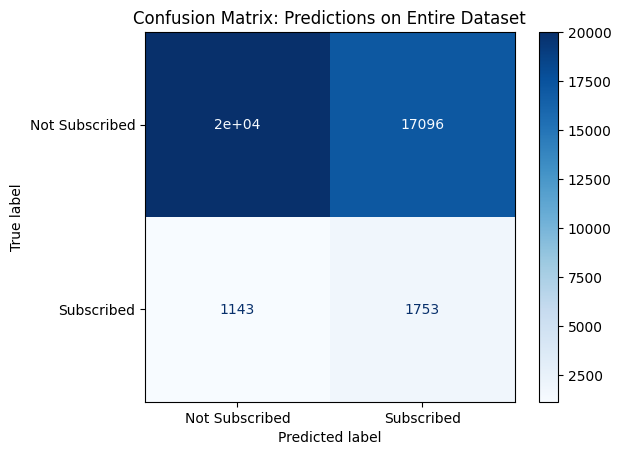


Accuracy: 0.5440

Classification Report:
                precision    recall  f1-score   support

Not Subscribed       0.95      0.54      0.69     37104
    Subscribed       0.09      0.61      0.16      2896

      accuracy                           0.54     40000
     macro avg       0.52      0.57      0.42     40000
  weighted avg       0.88      0.54      0.65     40000



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
# Confusion matrix
conf_matrix = confusion_matrix(y, y_pred)
conf_matrix_display = ConfusionMatrixDisplay(conf_matrix, display_labels=['Not Subscribed', 'Subscribed'])

# Plot the confusion matrix
conf_matrix_display.plot(cmap='Blues')
plt.title('Confusion Matrix: Predictions on Entire Dataset')
plt.show()


# Calculate and print the accuracy
accuracy = accuracy_score(y, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")

# Print classification report
# Here our model is predicting more than 37,000 customers as subscribers, this misses the point of using ML model here to reduce unwanted calls.
# Reduce unwanted calls
print("\nClassification Report:")
print(classification_report(y, y_pred, target_names=['Not Subscribed', 'Subscribed']))

Now we will calculate sum of total duration of calls of predicted subscribers and compare that with the total duraiton of calls for all 40,000 records to measure how much human effort we are saving in hours or seconds!


In [ ]:
# Step 1: Predict on the dataset
y_pred = bernoulli_nb.predict(X)

# Step 2: Add the predictions to the original DataFrame
X['predicted_subscribed'] = y_pred

X.head()

,age,balance,has_credit_default_yes,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,...,job_unemployed,job_unknown,marital_married,marital_single,education_secondary,education_tertiary,education_unknown,housing_loan?_yes,personal_loan_yes,predicted_subscribed
0,58,2143,False,False,False,False,True,False,False,False,...,False,False,True,False,False,True,False,True,False,no
1,44,29,False,False,False,False,False,False,False,False,...,False,False,False,True,True,False,False,True,False,yes
2,33,2,False,False,True,False,False,False,False,False,...,False,False,True,False,True,False,False,True,True,no
3,47,1506,False,True,False,False,False,False,False,False,...,False,False,True,False,False,False,True,True,False,no
4,33,1,False,False,False,False,False,False,False,False,...,False,True,False,True,False,False,True,False,False,no


In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   age                     40000 non-null  int64 
 1   balance                 40000 non-null  int64 
 2   has_credit_default_yes  40000 non-null  bool  
 3   job_blue-collar         40000 non-null  bool  
 4   job_entrepreneur        40000 non-null  bool  
 5   job_housemaid           40000 non-null  bool  
 6   job_management          40000 non-null  bool  
 7   job_retired             40000 non-null  bool  
 8   job_self-employed       40000 non-null  bool  
 9   job_services            40000 non-null  bool  
 10  job_student             40000 non-null  bool  
 11  job_technician          40000 non-null  bool  
 12  job_unemployed          40000 non-null  bool  
 13  job_unknown             40000 non-null  bool  
 14  marital_married         40000 non-null  bool  
 15  ma

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   age                             40000 non-null  int64 
 1   job                             40000 non-null  object
 2   marital                         40000 non-null  object
 3   education                       40000 non-null  object
 4   has_credit_default              40000 non-null  object
 5   balance                         40000 non-null  int64 
 6   housing_loan?                   40000 non-null  object
 7   personal_loan                   40000 non-null  object
 8   communication_type              40000 non-null  object
 9   last_contacted_day              40000 non-null  int64 
 10  last_contacted_month            40000 non-null  object
 11  contact_duration                40000 non-null  int64 
 12  number_of_contacts_in_campaign  40000 non-null

In [ ]:
# Step 3: Retrieve the 'duration' column from the original DataFrame (assuming it's called 'duration')
duration_column = df['contact_duration']

# Step 4: Add the 'duration' column back to the DataFrame
X['call_duration'] = duration_column

# Step 5: Filter the rows where 'predicted_subscribed' is 'Subscribed' (assuming 1 is subscribed)
subscribers_df = X[X['predicted_subscribed'] == 'yes']


# Step 6: Sum the 'duration' column for the filtered subscribers
total_duration_subscribers = subscribers_df['call_duration'].sum()
total_call_duration_all = X['call_duration'].sum()

In [ ]:
print(f"Total Duration for Predicted Subscribers (in hours): {total_duration_subscribers / 3600}")

Total Duration for Predicted Subscribers (in hours): 1328.8427777777779


In [ ]:
print(f"Total Duration for all calls made (in hours): {total_call_duration_all / 3600}")

Total Duration for all calls made (in hours): 2831.3811111111113



*   The total duration for all calls made: ~2,831 hours
*   The total duration for all calls made to predicted subscribers: ~1,329 hours

We are saving more than half the time for the startup by only selecting a subset of customers to call who are more likely to subscribe than others.

***Instead of calling 40,000 customers, by calling only 18,849 of them predicted by our model, we can save up to 1500 hours of call time!!***



In [ ]:
subscribers_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18849 entries, 1 to 39998
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   age                     18849 non-null  int64 
 1   balance                 18849 non-null  int64 
 2   has_credit_default_yes  18849 non-null  bool  
 3   job_blue-collar         18849 non-null  bool  
 4   job_entrepreneur        18849 non-null  bool  
 5   job_housemaid           18849 non-null  bool  
 6   job_management          18849 non-null  bool  
 7   job_retired             18849 non-null  bool  
 8   job_self-employed       18849 non-null  bool  
 9   job_services            18849 non-null  bool  
 10  job_student             18849 non-null  bool  
 11  job_technician          18849 non-null  bool  
 12  job_unemployed          18849 non-null  bool  
 13  job_unknown             18849 non-null  bool  
 14  marital_married         18849 non-null  bool  
 15  marital

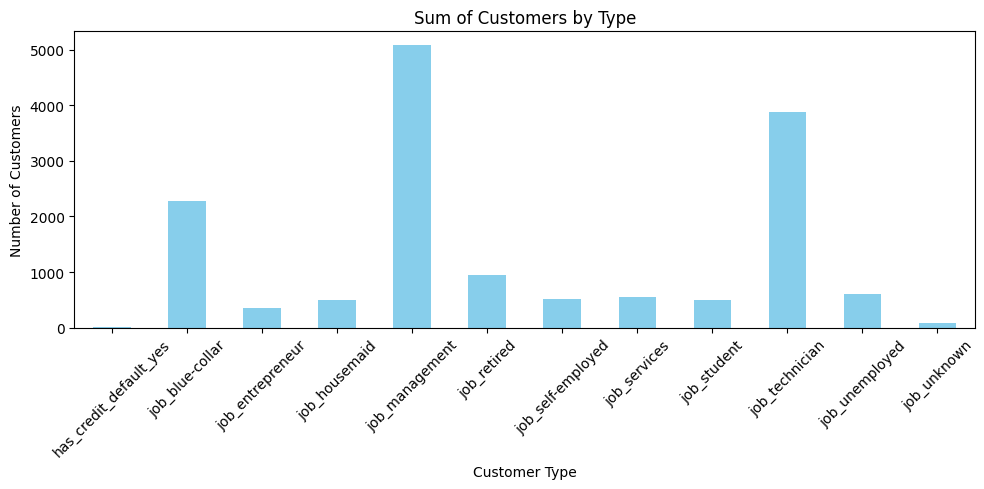

In [ ]:
# Assuming your DataFrame is called 'first_layer_df_encoded'
# Step 1: Select the relevant columns
customer_type_columns = [
    'has_credit_default_yes',
    'job_blue-collar',
    'job_entrepreneur',
    'job_housemaid',
    'job_management',
    'job_retired',
    'job_self-employed',
    'job_services',
    'job_student',
    'job_technician',
    'job_unemployed',
    'job_unknown'
]

# Step 2: Sum the values for each column to get the count of customers in each type
customer_type_counts = subscribers_df[customer_type_columns].sum()

# Step 3: Plot the bar chart
plt.figure(figsize=(10,5))
customer_type_counts.plot(kind='bar', color='skyblue')
plt.title('Sum of Customers by Type')
plt.xlabel('Customer Type')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

We see our ML model also focuses mainly on people with managerial level roles, technicians, retired individuals (this should not be the case) and also those who have defaulted before (this should also not be the case). Perhaps these two are causing our model to have a lower accuracy.

### 2nd Layer: Call Persistence (Retention Model)

Our 2nd layer will now focus on these predicted customers who are likely to subscribe. Now we will access campaign related data and build a ML model to predict which customers we should keep calling.

In [ ]:
# Instead of running the whole layer 1 code, we will now add code so we can resume from here
columns_to_add_back = ['communication_type', 'last_contacted_day', 'last_contacted_month', 'contact_duration', 'number_of_contacts_in_campaign', 'client_subscribed?']
X[columns_to_add_back] = df[columns_to_add_back]

In [ ]:
All_data = X
# Save the DataFrame as a CSV file
# Define the path where you want to save the file in Google Drive
csv_file_path = 'all_df.csv'
All_data.to_csv(csv_file_path, index=False)


print(f"DataFrame saved successfully to current directory!")

DataFrame saved successfully to current directory!


### 2nd Layer Data

In [ ]:
layer_2_data = pd.read_csv('all_df.csv')

In [ ]:
layer_2_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 29 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   age                             40000 non-null  int64 
 1   balance                         40000 non-null  int64 
 2   has_credit_default_yes          40000 non-null  bool  
 3   job_blue-collar                 40000 non-null  bool  
 4   job_entrepreneur                40000 non-null  bool  
 5   job_housemaid                   40000 non-null  bool  
 6   job_management                  40000 non-null  bool  
 7   job_retired                     40000 non-null  bool  
 8   job_self-employed               40000 non-null  bool  
 9   job_services                    40000 non-null  bool  
 10  job_student                     40000 non-null  bool  
 11  job_technician                  40000 non-null  bool  
 12  job_unemployed                  40000 non-null

In [ ]:
# Let us now drop the predicted_subscribed column as now there is no need for it, we will work with original predictions
layer_2_data = layer_2_data.drop(columns=['predicted_subscribed'])

In [ ]:
# Separate features (X) and target (y)
X = layer_2_data.drop(columns=['client_subscribed?'])
y = layer_2_data['client_subscribed?']

In [ ]:
# Step 2: Apply pd.get_dummies to categorical columns
X = pd.get_dummies(X, columns=['communication_type', 'last_contacted_day', 'last_contacted_month'], drop_first=True)

# Step 3: Train-test split (BEFORE applying SMOTE)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=random_seed)

In [ ]:
# Verify the shapes of the splits
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (30000, 66)
X_test shape: (10000, 66)
y_train shape: (30000,)
y_test shape: (10000,)


In [ ]:
X.head()

,age,balance,has_credit_default_yes,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,...,last_contacted_month_aug,last_contacted_month_dec,last_contacted_month_feb,last_contacted_month_jan,last_contacted_month_jul,last_contacted_month_jun,last_contacted_month_mar,last_contacted_month_may,last_contacted_month_nov,last_contacted_month_oct
0,58,2143,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,True,False,False
1,44,29,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2,33,2,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3,47,1506,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
4,33,1,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False


In [ ]:
# Now we will run lazy classifier to see which model perfomrs best in predicting which customers should we keep calling

# Select a random subset (e.g., 20% of the balanced training data) for faster model exploration
subset_percentage = 0.2
X_train_subset, y_train_subset = X_train.sample(frac=subset_percentage, random_state=random_seed), y_train.sample(frac=subset_percentage, random_state=random_seed)

from lazypredict.Supervised import LazyClassifier
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None, random_state=random_seed)
models, predictions = clf.fit(X_train_subset, X_test, y_train_subset, y_test)



print("LazyPredict Model Performance:")
print(models)

 87%|████████▋ | 27/31 [00:52<00:11,  2.98s/it]

[LightGBM] [Info] Number of positive: 435, number of negative: 5565
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016670 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 846
[LightGBM] [Info] Number of data points in the train set: 6000, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.072500 -> initscore=-2.548906
[LightGBM] [Info] Start training from score -2.548906


100%|██████████| 31/31 [00:54<00:00,  1.75s/it]

LazyPredict Model Performance:
                               Accuracy  Balanced Accuracy ROC AUC  F1 Score  \
Model                                                                          
NearestCentroid                    0.89               0.79    None      0.91   
PassiveAggressiveClassifier        0.90               0.77    None      0.91   
GaussianNB                         0.93               0.74    None      0.93   
LinearDiscriminantAnalysis         0.93               0.68    None      0.93   
QuadraticDiscriminantAnalysis      0.93               0.67    None      0.93   
SGDClassifier                      0.93               0.66    None      0.92   
ExtraTreeClassifier                0.90               0.64    None      0.90   
DecisionTreeClassifier             0.90               0.64    None      0.90   
AdaBoostClassifier                 0.93               0.63    None      0.92   
KNeighborsClassifier               0.93               0.63    None      0.92   
RandomFor

### Gaussian Naive Bayes

Classification algorithm based on Bayes Theorem, assumes features follow Normal distribution. This model estimates the mean and standard deviation for each feature & class, then uses these values to calculate probabilities during prediction

Generally used for text classification, spam filtering, etc



Accuracy: 0.8779

Classification Report:
                precision    recall  f1-score   support

Not Subscribed       0.97      0.90      0.93      9283
    Subscribed       0.32      0.60      0.41       717

      accuracy                           0.88     10000
     macro avg       0.64      0.75      0.67     10000
  weighted avg       0.92      0.88      0.89     10000



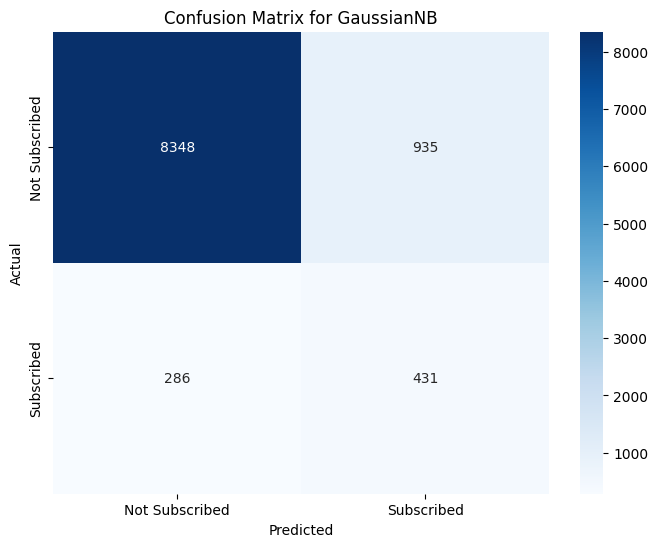

In [ ]:
# We will use the Gaussian NB model as it has the best overall results
# We are focusing on predicting which customers should we keep calling
# Target precision score for class 1 as out of all positive predictions, we need to be certain these customers will likely subscribe


from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Initialize GaussianNB model
gaussian_nb = GaussianNB()

# Step 2: Train the GaussianNB model
gaussian_nb.fit(X_train, y_train)

# Step 3: Predict on the test set
y_pred = gaussian_nb.predict(X_test)

# Step 4: Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Step 5: Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Not Subscribed', 'Subscribed']))

# Step 6: Generate and display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Subscribed', 'Subscribed'], yticklabels=['Not Subscribed', 'Subscribed'])
plt.title("Confusion Matrix for GaussianNB")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()




Currently, the precision score for class 1 is really poor which is against our requirements. We need a model that can minimize false positives (hence precision) so we can be confident that those customers that our model predicted as likely to subscribe will almost certainly subscribe at the end and thus, we can target these customers for further calls.

Let us perform hyperparamter tuning using hyperopt to optimize the parameter var_smoothing

In [ ]:
layer_2_data['client_subscribed?'].value_counts()

,count
client_subscribed?,
no,37104
yes,2896


Use SMOTE Tomek Links to oversample the data and have a more balanced yet realistic dataset.

In [ ]:
# Import necessary libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.combine import SMOTETomek
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Initialize SMOTE-Tomek to balance the classes
smote_tomek = SMOTETomek(random_state=random_seed)

# Step 2: Apply SMOTE-Tomek to the training data
X_train_resampled, y_train_resampled = smote_tomek.fit_resample(X_train, y_train)


In [ ]:
# Import necessary libraries
from hyperopt import hp, tpe, fmin, Trials  # Used for hyperparameter optimization
from sklearn.naive_bayes import GaussianNB  # Gaussian Naive Bayes model
from sklearn.metrics import precision_score  # Metric to evaluate precision
from sklearn.model_selection import train_test_split, cross_val_score  # For splitting the data and cross-validation

# Define the objective function that HyperOpt will minimize
def objective(space):
    # Step 1: Initialize the Gaussian Naive Bayes model with the current 'var_smoothing' value from HyperOpt
    model = GaussianNB(var_smoothing=space['var_smoothing'])

    # Step 2: Train the model using the training data (X_train, y_train)
    model.fit(X_train_resampled, y_train_resampled)

    # Step 3: Use the trained model to make predictions on the test set (X_test)
    y_pred = model.predict(X_test)

    # Step 4: Calculate the precision score for the positive class ('yes' = subscribed customers)
    # pos_label='yes' ensures that we calculate precision specifically for the "Subscribed" class
    precision_class_1 = precision_score(y_test, y_pred, pos_label='yes')

    # Step 5: Since HyperOpt minimizes the objective function, we return the negative precision.
    # By minimizing the negative precision, we are effectively maximizing the precision for class 1.
    return -precision_class_1


# Define the hyperparameter search space for 'var_smoothing'.
# 'var_smoothing' is a parameter of the Gaussian Naive Bayes model, which helps to stabilize low variances.
# We are using a logarithmic uniform distribution to explore values of 'var_smoothing' in the range [1e-9, 1e0].
space = {
    'var_smoothing': hp.loguniform('var_smoothing', -9, 0)  # Values between 1e-9 and 1e0
}


# Initialize a Trials object to store details of each trial performed by HyperOpt
trials = Trials()

# Use the fmin() function from HyperOpt to find the optimal hyperparameter value.
# - fn: The objective function we want to minimize (in this case, it is the negative precision score).
# - space: The hyperparameter search space for 'var_smoothing'.
# - algo: The optimization algorithm. We are using 'tpe.suggest', which stands for Tree of Parzen Estimators, a common algorithm for HyperOpt.
# - max_evals: The number of iterations (trials) HyperOpt will run to find the best parameter value.
# - trials: The Trials object that stores the results of each trial.
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,  # Optimization algorithm
            max_evals=100,  # Run 100 trials to find the best 'var_smoothing'
            trials=trials)

# Print the best hyperparameters found after 100 trials
print(f"Best hyperparameters: {best}")


# Step 6: Retrieve the best value for 'var_smoothing' that was found by HyperOpt
best_var_smoothing = best['var_smoothing']

# Step 7: Initialize a new GaussianNB model using the best 'var_smoothing' value
best_gaussian_nb = GaussianNB(var_smoothing=best_var_smoothing)

# Step 8: Train the model with the training data using the optimized 'var_smoothing' parameter
best_gaussian_nb.fit(X_train_resampled, y_train_resampled)






100%|██████████| 100/100 [00:33<00:00,  2.95trial/s, best loss: -0.4197651663405088]
Best hyperparameters: {'var_smoothing': 0.016221423452278304}


GaussianNB(var_smoothing=0.016221423452278304)

In [ ]:
# Step 9: Make predictions on the test data
y_pred_best = best_gaussian_nb.predict(X_test)

# Step 10: Calculate the precision score for class 1 ('Subscribed') using the optimized model
precision_class_1_best = precision_score(y_test, y_pred_best, pos_label='yes')

# Print the precision score for class 1 after hyperparameter tuning
print(f"Precision for class 1 after tuning: {precision_class_1_best:.4f}")

Precision for class 1 after tuning: 0.4198


Accuracy: 0.9119

Classification Report:
                precision    recall  f1-score   support

Not Subscribed       0.97      0.94      0.95      9283
    Subscribed       0.42      0.60      0.49       717

      accuracy                           0.91     10000
     macro avg       0.69      0.77      0.72     10000
  weighted avg       0.93      0.91      0.92     10000



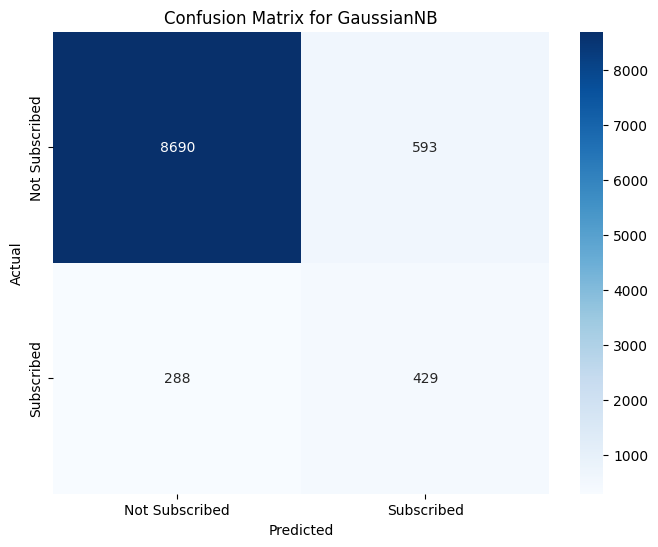

In [ ]:
# Step 4: Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_best)
print(f"Accuracy: {accuracy:.4f}")

# Step 5: Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best, target_names=['Not Subscribed', 'Subscribed']))

# Step 6: Generate and display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Subscribed', 'Subscribed'], yticklabels=['Not Subscribed', 'Subscribed'])
plt.title("Confusion Matrix for GaussianNB")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



100%|██████████| 100/100 [00:32<00:00,  3.11trial/s, best loss: -0.4201762977473066]
Best hyperparameters: {'var_smoothing': 0.016638728534048512}
Accuracy: 0.9307

Classification Report:
                precision    recall  f1-score   support

Not Subscribed       0.94      0.99      0.96      9283
    Subscribed       0.54      0.21      0.30       717

      accuracy                           0.93     10000
     macro avg       0.74      0.60      0.63     10000
  weighted avg       0.91      0.93      0.92     10000



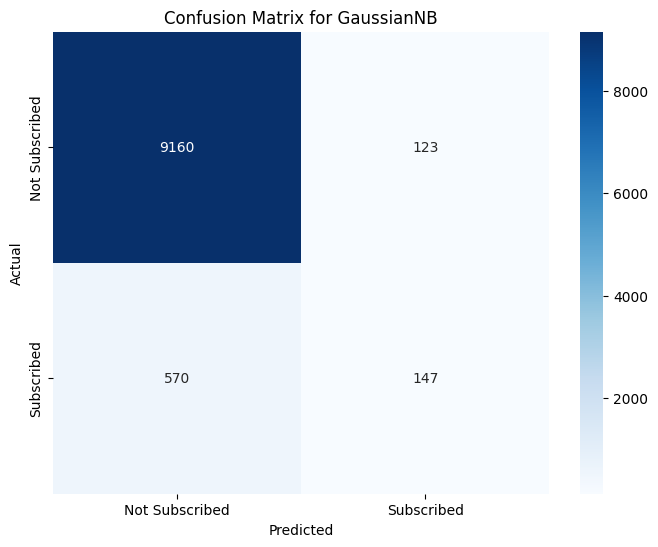

In [ ]:
# Let us see without using the oversampled dataset


# Initialize a Trials object to store details of each trial performed by HyperOpt
trials = Trials()

# Use the fmin() function from HyperOpt to find the optimal hyperparameter value.
# - fn: The objective function we want to minimize (in this case, it is the negative precision score).
# - space: The hyperparameter search space for 'var_smoothing'.
# - algo: The optimization algorithm. We are using 'tpe.suggest', which stands for Tree of Parzen Estimators, a common algorithm for HyperOpt.
# - max_evals: The number of iterations (trials) HyperOpt will run to find the best parameter value.
# - trials: The Trials object that stores the results of each trial.
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,  # Optimization algorithm
            max_evals=100,  # Run 100 trials to find the best 'var_smoothing'
            trials=trials)

# Print the best hyperparameters found after 100 trials
print(f"Best hyperparameters: {best}")


# Step 6: Retrieve the best value for 'var_smoothing' that was found by HyperOpt
best_var_smoothing = best['var_smoothing']

# Step 7: Initialize a new GaussianNB model using the best 'var_smoothing' value
best_gaussian_nb = GaussianNB(var_smoothing=best_var_smoothing)

# Step 8: Train the model with the training data using the optimized 'var_smoothing' parameter
best_gaussian_nb.fit(X_train, y_train)
# Step 9: Make predictions on the test data
y_pred_best = best_gaussian_nb.predict(X_test)


# Step 4: Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_best)
print(f"Accuracy: {accuracy:.4f}")

# Step 5: Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best, target_names=['Not Subscribed', 'Subscribed']))

# Step 6: Generate and display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Subscribed', 'Subscribed'], yticklabels=['Not Subscribed', 'Subscribed'])
plt.title("Confusion Matrix for GaussianNB")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()





It seems Smote Tomek gives us poorer results, we will avoid using it.

We can experiment with another model as hyperparameter tuning did not give much promising results for precision. We will go with random forest and then adjust class weights as needed to favor precision more

Accuracy: 0.9360

Classification Report:
                precision    recall  f1-score   support

Not Subscribed       0.95      0.99      0.97      9283
    Subscribed       0.62      0.27      0.38       717

      accuracy                           0.94     10000
     macro avg       0.78      0.63      0.67     10000
  weighted avg       0.92      0.94      0.92     10000



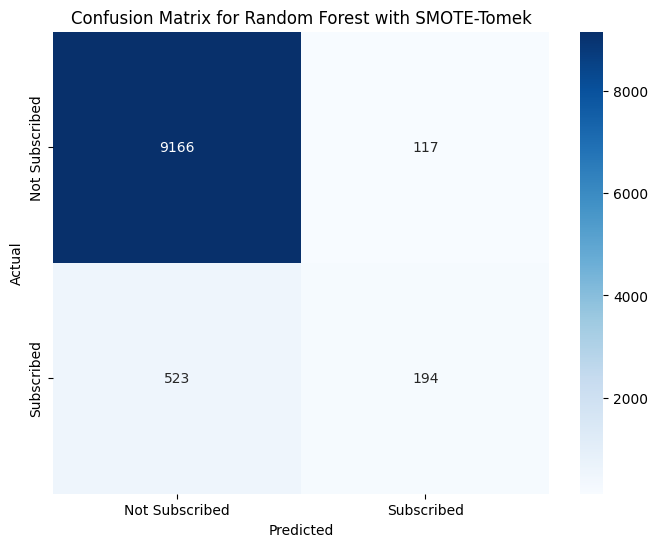

In [ ]:

# Step 3: Initialize RandomForestClassifier with custom class weights
custom_weights = {'no': 1, 'yes': 10}  # Assigning higher weight to class 'yes' (Subscribed)
random_forest = RandomForestClassifier(class_weight=custom_weights, random_state=random_seed)

# Step 4: Train the RandomForestClassifier model on the resampled data
random_forest.fit(X_train, y_train)

# Step 5: Predict on the original test set
y_pred = random_forest.predict(X_test)

# Step 6: Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Step 7: Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Not Subscribed', 'Subscribed']))

# Step 8: Generate and display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Subscribed', 'Subscribed'], yticklabels=['Not Subscribed', 'Subscribed'])
plt.title("Confusion Matrix for Random Forest with SMOTE-Tomek")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
# Import HyperOpt and necessary libraries
from hyperopt import hp, tpe, fmin, Trials
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
from sklearn.model_selection import train_test_split, cross_val_score

In [ ]:
# Step 1: Define the search space for Random Forest hyperparameters
# Step 1: Define the search space for Random Forest hyperparameters
space = {
    'max_depth': hp.choice('max_depth', range(2, 20, 2)),  # Maximum depth of the trees
}

# Step 2: Define the objective function that HyperOpt will minimize
def objective(params):
    # Initialize the RandomForestClassifier with the given hyperparameters
    model = RandomForestClassifier(
        max_depth=params['max_depth'],
        random_state=42
    )

    # Train the model on the training data
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate accuracy on the test set
    accuracy = accuracy_score(y_test, y_pred)

    # Return the negative accuracy score (because HyperOpt minimizes the objective function)
    return -accuracy

# Step 3: Initialize a Trials object to track the results of each trial
trials = Trials()

# Step 4: Run the HyperOpt optimization process
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,  # Optimization algorithm
            max_evals=20,  # Number of trials to run
            trials=trials)

# Step 5: Print the best hyperparameters found
print(f"Best hyperparameters: {best}")


100%|██████████| 20/20 [01:07<00:00,  3.38s/trial, best loss: -0.9387]
Best hyperparameters: {'max_depth': 8}


In [ ]:


# Step 6: Train the Random Forest model with the best hyperparameters and custom weights

# Step 3: Initialize RandomForestClassifier with custom class weights
custom_weights = {'no': 1, 'yes': 1}  # Assigning higher weight to class 'yes' (Subscribed)
random_forest = RandomForestClassifier(class_weight=custom_weights, random_state=random_seed)

best_random_forest = RandomForestClassifier(
    max_depth=8,
    random_state=random_seed,
    class_weight=custom_weights
)


In [ ]:


# Train the RandomForest with the best found hyperparameters
best_random_forest.fit(X_train, y_train)

# Predict on the test set
y_pred_best = best_random_forest.predict(X_test)

# Calculate precision for class 1 (Subscribed)
precision_class_1_best = precision_score(y_test, y_pred_best, pos_label='yes')
accuracy = accuracy_score(y_test, y_pred)
print(f"Precision for class 1 after tuning: {precision_class_1_best:.4f}")
print(f"Accuracy Score: {accuracy:.4f}")

# Step 7: Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best, target_names=['Not Subscribed', 'Subscribed']))


Precision for class 1 after tuning: 0.6575
Accuracy Score: 0.9360

Classification Report:
                precision    recall  f1-score   support

Not Subscribed       0.93      1.00      0.96      9283
    Subscribed       0.66      0.07      0.12       717

      accuracy                           0.93     10000
     macro avg       0.80      0.53      0.54     10000
  weighted avg       0.91      0.93      0.90     10000



Still the results are not as we required, we will experiment with a lot more models and select the one with the highest precision score for class 1.

In [ ]:
# Import necessary libraries and classifiers
from sklearn.linear_model import PassiveAggressiveClassifier, SGDClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.tree import ExtraTreeClassifier, DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, classification_report
from imblearn.combine import SMOTETomek
from sklearn.model_selection import train_test_split

# Adjusted class weights to favor the "Subscribed" class
class_weights = {'no': 1, 'yes': 1.2}

# Dictionary to store classifiers with class weight parameters
classifiers = {
    'PassiveAggressiveClassifier': PassiveAggressiveClassifier(random_state=random_seed, class_weight=class_weights),
    'SGDClassifier': SGDClassifier(random_state=random_seed, class_weight=class_weights),
    'ExtraTreeClassifier': ExtraTreeClassifier(random_state=random_seed, class_weight=class_weights),
    'DecisionTreeClassifier': DecisionTreeClassifier(random_state=random_seed, class_weight=class_weights),
    'AdaBoostClassifier': AdaBoostClassifier(random_state=random_seed)  # AdaBoost doesn't have a class_weight parameter
}

# Iterate through classifiers and evaluate each
for name, clf in classifiers.items():
    # Train the classifier
    clf.fit(X_train, y_train)

    # Predict on the test set
    y_pred = clf.predict(X_test)

    # Calculate precision for class 1 (Subscribed)
    precision_class_1 = precision_score(y_test, y_pred, pos_label='yes')

    # Print results
    print(f"{name} - Precision for class 1 (Subscribed): {precision_class_1:.4f}")

    # Print classification report for further details
    print(classification_report(y_test, y_pred, target_names=['Not Subscribed', 'Subscribed']))
    print("-" * 50)


PassiveAggressiveClassifier - Precision for class 1 (Subscribed): 0.0000
                precision    recall  f1-score   support

Not Subscribed       0.93      1.00      0.96      9283
    Subscribed       0.00      0.00      0.00       717

      accuracy                           0.93     10000
     macro avg       0.46      0.50      0.48     10000
  weighted avg       0.86      0.93      0.89     10000

--------------------------------------------------
SGDClassifier - Precision for class 1 (Subscribed): 0.5687
                precision    recall  f1-score   support

Not Subscribed       0.94      0.99      0.96      9283
    Subscribed       0.57      0.17      0.26       717

      accuracy                           0.93     10000
     macro avg       0.75      0.58      0.61     10000
  weighted avg       0.91      0.93      0.91     10000

--------------------------------------------------
ExtraTreeClassifier - Precision for class 1 (Subscribed): 0.3905
                precisi

Random forest model performs the best with 66% precision for Class 1 so we will save that model & will move on to layer 3 of the problem

In [ ]:
# Save the trained RandomForest model using pickle
with open('random_forest_model.pkl', 'wb') as model_file:
    pickle.dump(best_random_forest, model_file)


In [ ]:
with open('random_forest_model.pkl', 'rb') as model_file:
    loaded_random_forest = pickle.load(model_file)


# Predict on the test set
y_pred_best = loaded_random_forest.predict(X_test)

# Calculate precision for class 1 (Subscribed) and accuracy
precision_class_1_best = precision_score(y_test, y_pred_best, pos_label='yes')
accuracy = accuracy_score(y_test, y_pred_best)
print(f"Precision for class 1 after tuning: {precision_class_1_best:.4f}")
print(f"Accuracy Score: {accuracy:.4f}")

# Print the classification report on the test set
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_pred_best, target_names=['Not Subscribed', 'Subscribed']))

Precision for class 1 after tuning: 0.6575
Accuracy Score: 0.9306

Classification Report on Test Set:
                precision    recall  f1-score   support

Not Subscribed       0.93      1.00      0.96      9283
    Subscribed       0.66      0.07      0.12       717

      accuracy                           0.93     10000
     macro avg       0.80      0.53      0.54     10000
  weighted avg       0.91      0.93      0.90     10000



Let us aim for better recall score as well here as we are also trading or losing out on a lot of subscribers with this model. We will focus on the F2 score here.

F2 score is a varieant of the F-beta score, which is a measure of a model's performance that gives more weight to recall than to precision.

F-B = (1 + B**2) x (precision x recall) / (B**2 x precision) + recall

F2 score would be B=2, here recall is being weigted x4 more than actual positives.

In [ ]:
from sklearn.metrics import fbeta_score, accuracy_score, classification_report

In [ ]:
# Step 1: Define the search space for Random Forest hyperparameters
space = {
    'max_depth': hp.choice('max_depth', range(2, 30, 2)),  # Maximum depth of the trees
    'criterion': hp.choice('criterion', ['gini', 'entropy']),  # Criterion for splitting
    'max_features': hp.choice('max_features', ['sqrt', 'log2', None]),  # Removed 'auto'
}

# Import necessary metrics

# Step 2: Define the objective function that HyperOpt will minimize
def objective(params):
    # Initialize the RandomForestClassifier with the given hyperparameters
    model = RandomForestClassifier(
        max_depth=params['max_depth'],
        criterion=params['criterion'],
        max_features=params['max_features'],
        class_weight='balanced',  # Adjust for imbalanced classes
        random_state=random_seed
    )

    # Train the model on the training data
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate the F2 score to prioritize recall even more
    f2_score_class_1 = fbeta_score(y_test, y_pred, pos_label='yes', beta=2)

    # Return the negative F2 score (because HyperOpt minimizes the objective function)
    return -f2_score_class_1

# Step 3: Initialize a Trials object to track the results of each trial
trials = Trials()

# Step 4: Run the HyperOpt optimization process
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,  # Optimization algorithm
            max_evals=20,  # Number of trials to run
            trials=trials)

# Step 5: Print the best hyperparameters found
print(f"Best hyperparameters: {best}")




100%|██████████| 20/20 [02:28<00:00,  7.42s/trial, best loss: -0.6671934974034771]
Best hyperparameters: {'criterion': 0, 'max_depth': 4, 'max_features': 2}


In [ ]:
custom_weights = {'no': 1, 'yes': 1.3}  # Assigning higher weight to class 'yes' (Subscribed)

best =  {'criterion': 0, 'max_depth': 4, 'max_features': 2}

# Step 6: Train the RandomForest with the best found hyperparameters
best_model = RandomForestClassifier(
    max_depth=best['max_depth'],
    criterion=['gini', 'entropy'][best['criterion']],  # Convert index to actual value
    max_features=['sqrt', 'log2', None][best['max_features']],
    class_weight=custom_weights,
    random_state=random_seed
)

# Fit the model with the best hyperparameters on the training data
best_model.fit(X_train, y_train)

# Predict on the test set
y_pred_best = best_model.predict(X_test)

# Calculate F2 score for class 1 (Subscribed)
f2_score_class_1_best = fbeta_score(y_test, y_pred_best, pos_label='yes', beta=2)
accuracy = accuracy_score(y_test, y_pred_best)
print(f"F2 Score for class 1 after tuning: {f2_score_class_1_best:.4f}")
print(f"Accuracy Score: {accuracy:.4f}")

# Step 7: Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best, target_names=['Not Subscribed', 'Subscribed']))

F2 Score for class 1 after tuning: 0.4477
Accuracy Score: 0.9391

Classification Report:
                precision    recall  f1-score   support

Not Subscribed       0.96      0.98      0.97      9283
    Subscribed       0.61      0.42      0.50       717

      accuracy                           0.94     10000
     macro avg       0.78      0.70      0.73     10000
  weighted avg       0.93      0.94      0.93     10000



The score above represents the optimal balance between precision and recall, allowing us to achieve a high precision while maintaining a reasonable recall to capture a significant number of subscribers. Let's save this model as the best model for layer 2 of the term deposit marketing problem.

In [ ]:
import pickle

# Save the best_model as "layer_2_model.pkl" using pickle
with open("layer_2_model.pkl", "wb") as file:
    pickle.dump(best_model, file)

print("Model saved as layer_2_model.pkl")


Model saved as layer_2_model.pkl


In [ ]:
with open("layer_2_model.pkl", "rb") as file:
    loaded_model = pickle.load(file)


# Predict on the test set
y_pred_best = loaded_model.predict(X_test)

# Calculate F2 score for class 1 (Subscribed)
f2_score_class_1_best = fbeta_score(y_test, y_pred_best, pos_label='yes', beta=2)
accuracy = accuracy_score(y_test, y_pred_best)
print(f"F2 Score for class 1 after tuning: {f2_score_class_1_best:.4f}")
print(f"Accuracy Score: {accuracy:.4f}")

# Step 7: Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best, target_names=['Not Subscribed', 'Subscribed']))


F2 Score for class 1 after tuning: 0.4477
Accuracy Score: 0.9391

Classification Report:
                precision    recall  f1-score   support

Not Subscribed       0.96      0.98      0.97      9283
    Subscribed       0.61      0.42      0.50       717

      accuracy                           0.94     10000
     macro avg       0.78      0.70      0.73     10000
  weighted avg       0.93      0.94      0.93     10000



In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=random_seed)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


In [ ]:
from sklearn.metrics import fbeta_score, classification_report, accuracy_score
from sklearn.linear_model import PassiveAggressiveClassifier
from imblearn.over_sampling import SMOTE
from hyperopt import hp, fmin, tpe, Trials

# Address imbalance with SMOTE
smote = SMOTE(random_state=random_seed)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Define search space
space = {
    'C': hp.uniform('C', 0.01, 10),
    'max_iter': hp.choice('max_iter', [200, 500, 1000]),
    'tol': hp.loguniform('tol', -6, -1),
    'loss': hp.choice('loss', ['hinge', 'squared_hinge'])
}

# Objective function
def objective(params):
    model = PassiveAggressiveClassifier(
        C=params['C'],
        max_iter=params['max_iter'],
        tol=params['tol'],
        loss=params['loss'],
        class_weight='balanced',
        random_state=random_seed
    )
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test)
    return -fbeta_score(y_test, y_pred, pos_label='yes', beta=2)

# Hyperparameter tuning
trials = Trials()
best = fmin(objective, space, algo=tpe.suggest, max_evals=50, trials=trials)



100%|██████████| 50/50 [01:15<00:00,  1.51s/trial, best loss: -0.581200669696245]


In [ ]:
print(best)

{'C': 2.567602119650547, 'loss': 1, 'max_iter': 2, 'tol': 0.0025758633487298604}


In [ ]:
custom_weights = {'no': 1, 'yes': 5}  # Assigning higher weight to class 'yes' (Subscribed)


# Step 6: Train the RandomForest with the best found hyperparameters
best_model = PassiveAggressiveClassifier(
    C=best['C'],
    loss=['hinge', 'squared_hinge'][best['loss']],  # Convert index to actual value
    max_iter=best['max_iter'],  # Convert index to actual value
    tol=best['tol'],  # Convert index to actual value
    class_weight=custom_weights,
    random_state=random_seed
)

# Fit the model with the best hyperparameters on the training data
best_model.fit(X_train_resampled, y_train_resampled)

# Predict on the test set
y_pred_best = best_model.predict(X_test)

# Calculate F2 score for class 1 (Subscribed)
f2_score_class_1_best = fbeta_score(y_test, y_pred_best, pos_label='yes', beta=2)
accuracy = accuracy_score(y_test, y_pred_best)
print(f"F2 Score for class 1 after tuning: {f2_score_class_1_best:.4f}")
print(f"Accuracy Score: {accuracy:.4f}")

# Step 7: Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best, target_names=['Not Subscribed', 'Subscribed']))

F2 Score for class 1 after tuning: 0.4810
Accuracy Score: 0.8566

Classification Report:
                precision    recall  f1-score   support

Not Subscribed       0.97      0.88      0.92      9283
    Subscribed       0.27      0.60      0.37       717

      accuracy                           0.86     10000
     macro avg       0.62      0.74      0.65     10000
  weighted avg       0.92      0.86      0.88     10000



In [ ]:
custom_weights = {'no': 1, 'yes': 6}  # Assigning higher weight to class 'yes' (Subscribed)


# Step 6: Train the RandomForest with the best found hyperparameters
best_model = PassiveAggressiveClassifier(
    C=best['C'],
    loss=['hinge', 'squared_hinge'][best['loss']],  # Convert index to actual value
    max_iter=best['max_iter'],  # Convert index to actual value
    tol=best['tol'],  # Convert index to actual value
    class_weight=custom_weights,
    random_state=random_seed
)

# Fit the model with the best hyperparameters on the training data
best_model.fit(X_train, y_train)

# Predict on the test set
y_pred_best = best_model.predict(X_test)

# Calculate F2 score for class 1 (Subscribed)
f2_score_class_1_best = fbeta_score(y_test, y_pred_best, pos_label='yes', beta=2)
accuracy = accuracy_score(y_test, y_pred_best)
print(f"F2 Score for class 1 after tuning: {f2_score_class_1_best:.4f}")
print(f"Accuracy Score: {accuracy:.4f}")

# Step 7: Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best, target_names=['Not Subscribed', 'Subscribed']))

F2 Score for class 1 after tuning: 0.4158
Accuracy Score: 0.8712

Classification Report:
                precision    recall  f1-score   support

Not Subscribed       0.96      0.90      0.93      9283
    Subscribed       0.27      0.48      0.35       717

      accuracy                           0.87     10000
     macro avg       0.62      0.69      0.64     10000
  weighted avg       0.91      0.87      0.89     10000



In [ ]:
from xgboost import XGBClassifier
from hyperopt import hp, fmin, tpe, Trials
from sklearn.metrics import fbeta_score, classification_report, accuracy_score

# Define the search space for XGBoost hyperparameters
space = {
    'max_depth': hp.choice('max_depth', range(3, 15)),  # Tree depth
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),  # Learning rate
    'n_estimators': hp.choice('n_estimators', range(50, 500, 50)),  # Number of trees
    'subsample': hp.uniform('subsample', 0.5, 1.0),  # Subsample ratio
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),  # Feature subsampling ratio
    'scale_pos_weight': hp.uniform('scale_pos_weight', 1, 10),  # For imbalanced classes
    'gamma': hp.uniform('gamma', 0, 5),  # Regularization
}

from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode the target labels
y_train_encoded = label_encoder.fit_transform(y_train)  # Convert 'yes'/'no' to 1/0
y_test_encoded = label_encoder.transform(y_test)


def objective(params):
    model = XGBClassifier(
        max_depth=params['max_depth'],
        learning_rate=params['learning_rate'],
        n_estimators=params['n_estimators'],
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        scale_pos_weight=params['scale_pos_weight'],
        gamma=params['gamma'],
        random_state=random_seed,
        use_label_encoder=False,
        eval_metric='logloss'
    )

    # Train the model with encoded labels
    model.fit(X_train, y_train_encoded)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate F2 score for the positive class
    f2_score_class_1 = fbeta_score(y_test_encoded, y_pred, pos_label=1, beta=2)

    # Minimize the negative F2 score
    return -f2_score_class_1


# Initialize Trials object
trials = Trials()

# Run the HyperOpt optimization process
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20,  # Number of trials
            trials=trials)




100%|██████████| 20/20 [01:10<00:00,  3.51s/trial, best loss: -0.6887565152643336]


In [ ]:
best

{'colsample_bytree': 0.6925868859036165,
 'gamma': 2.727915968974309,
 'learning_rate': 0.08019462067346798,
 'max_depth': 4,
 'n_estimators': 3,
 'scale_pos_weight': 6.51523692716147,
 'subsample': 0.5423999536772314}

In [ ]:
# Resolve best hyperparameters
best_params = {
    'max_depth': range(3, 15)[best['max_depth']],
    'learning_rate': best['learning_rate'],
    'n_estimators': range(50, 500, 50)[best['n_estimators']],
    'subsample': best['subsample'],
    'colsample_bytree': best['colsample_bytree'],
    'scale_pos_weight': 7, # favour the yes class even more
    'gamma': best['gamma'],
}

print(f"Best hyperparameters: {best_params}")

# Train XGBoost with the best parameters
best_model = XGBClassifier(
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    n_estimators=best_params['n_estimators'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    scale_pos_weight=best_params['scale_pos_weight'],
    gamma=best_params['gamma'],
    random_state=random_seed,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Train the model
best_model.fit(X_train, y_train_encoded)

# Evaluate the model
y_pred_best = best_model.predict(X_test)
# Decode the predictions back to original string labels
y_pred_best = label_encoder.inverse_transform(y_pred_best)
f2_score_class_1_best = fbeta_score(y_test, y_pred_best, pos_label='yes', beta=2)
accuracy = accuracy_score(y_test, y_pred_best)

# Print results
print(f"F2 Score for class 1 after tuning: {f2_score_class_1_best:.4f}")
print(f"Accuracy Score: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best, target_names=['Not Subscribed', 'Subscribed']))

Best hyperparameters: {'max_depth': 7, 'learning_rate': 0.08019462067346798, 'n_estimators': 200, 'subsample': 0.5423999536772314, 'colsample_bytree': 0.6925868859036165, 'scale_pos_weight': 7, 'gamma': 2.727915968974309}
F2 Score for class 1 after tuning: 0.6929
Accuracy Score: 0.9225

Classification Report:
                precision    recall  f1-score   support

Not Subscribed       0.98      0.93      0.96      9283
    Subscribed       0.48      0.78      0.59       717

      accuracy                           0.92     10000
     macro avg       0.73      0.86      0.77     10000
  weighted avg       0.95      0.92      0.93     10000



In [ ]:
import pickle

# Save the trained model to a pickle file
with open('best_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)

print("Model saved as 'best_model.pkl'")


Model saved as 'best_model.pkl'


In [ ]:
# Load the model from the pickle file
with open('best_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

print("Model loaded successfully")

# Use the loaded model to make predictions
y_pred_loaded = loaded_model.predict(X_test)
y_pred_loaded = label_encoder.inverse_transform(y_pred_loaded)
f2_score_loaded = fbeta_score(y_test, y_pred_loaded, pos_label='yes', beta=2)
accuracy_loaded = accuracy_score(y_test, y_pred_loaded)

print(f"F2 Score (Loaded Model): {f2_score_loaded:.4f}")
print(f"Accuracy (Loaded Model): {accuracy_loaded:.4f}")


Model loaded successfully
F2 Score (Loaded Model): 0.6929
Accuracy (Loaded Model): 0.9225


In [ ]:
# Step 7: Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_loaded, target_names=['Not Subscribed', 'Subscribed']))


Classification Report:
                precision    recall  f1-score   support

Not Subscribed       0.98      0.93      0.96      9283
    Subscribed       0.48      0.78      0.59       717

      accuracy                           0.92     10000
     macro avg       0.73      0.86      0.77     10000
  weighted avg       0.95      0.92      0.93     10000



Business Value:
**bold text**
*   Enhanced Targeting: By capturing 78% of likely subscribers, the model enables the marketing team to design more focused and cost-effective campaigns.
*   Retention Strategies: Identifying non-subscribers allows the company to implement tailored strategies to convert them into loyal customers.
*   Improved ROI: A data-driven approach ensures resources are allocated efficiently, maximizing the return on investment for customer acquisition efforts.
*   While the precision indicates the model is 48% confident in its prediction for a "Subscribed" customer, this trade-off is **balanced by the high recall, ensuring we don't overlook potential subscribers**.






### 3rd Layer: Subscriber Segmentation (Unsupervised Learning)


So far, to summarize the progress:

Layer 1:


1.   The best model was Bernoulli NB & final recall score for Class 1 was 62%
2.   Meanwhile the accuracy was 54% and around 80% after evaluating across 5 folds. Even with techniques such as stacking and voting classifiers, the performance on recall for class 1 and accuracy did not meet our requirements.

Layer 2:

1. Best overall model evaluated was Random Forest while prioritizing F2-score with precision for class 1 as 61% while accuracy was much higher this time ~ 93%. We also capture a good number of subscribers with recall score as 42%.


Now our focus will be to analyze and understand who our customers are and segment them to allow us for better targeting. We will only look at those who are current subscribers and see how many segments these customers fall into and whether we can detect any themes or patterns.

This can help us in designing marketing campaigns and calls tailored to each customer segment.



### Approach to performing unsupervised learning to tackle layer 3 of the problem.

1.   Import data & perform one-hot encoding
2.   Filter the data to only current subscribers
3.   Scale the data & use Principal Component Analysis (PCA) to reduce the number of features while retaining as much information as possible to avoid noise.
4.   Use K-Means Clustering to partition data into distinct groups - works by minimizing distance between each customer and center of cluster to which they are assigned
5.   Utilize the "Elbow Method" to choose the optimal number of clusters based on the dataset as we need to decide initially how many segments we need to cluster our customers into. We will use ***Inertia Score*** to evaluate the quality of clusters.
6.   After these clusters are formed, we will analyze the characteristics of customers for each cluster example one cluster may contains customers who are older with high balances and loans etc.

We will take the clusters column & add that to our initial dataset so we can easily perform EDA with the newly added cluster column.



In [11]:
# Original dataset - Adding the clusters column in original dataset
# We need to see the demographics for these two clusters
layer_3_data = pd.read_csv('term-deposit-marketing-2020.csv')
# First, let's create a dictionary mapping the old column names to the new ones
column_mapping = {
    'default': 'has_credit_default',
    'loan': 'personal_loan',
    'contact': 'communication_type',
    'day': 'last_contacted_day',
    'month': 'last_contacted_month',
    'duration': 'contact_duration',
    'campaign': 'number_of_contacts_in_campaign',
    'housing': 'housing_loan?',
    'y' : 'client_subscribed?'
}

# Now, let's rename the columns
layer_3_data = layer_3_data.rename(columns=column_mapping)

# Filter only for subscriber data
original_layer_3_data = layer_3_data[layer_3_data['client_subscribed?'] == 'yes']

In [12]:
# Reset the index and drop the old index column
original_layer_3_data = original_layer_3_data.reset_index(drop=True)

In [13]:
# Perform One-Hot Encoding for categorical variables
layer_3_data_encoded = pd.get_dummies(original_layer_3_data, columns=[
    'job', 'marital', 'education', 'has_credit_default', 'housing_loan?', 'personal_loan',
    'communication_type', 'last_contacted_month'
])

In [14]:
layer_3_data_encoded.head(2)

,age,balance,last_contacted_day,contact_duration,number_of_contacts_in_campaign,client_subscribed?,job_admin,job_blue-collar,job_entrepreneur,job_housemaid,...,last_contacted_month_aug,last_contacted_month_dec,last_contacted_month_feb,last_contacted_month_jan,last_contacted_month_jul,last_contacted_month_jun,last_contacted_month_mar,last_contacted_month_may,last_contacted_month_nov,last_contacted_month_oct
0,59,2343,5,1042,1,yes,True,False,False,False,...,False,False,False,False,False,False,False,True,False,False
1,56,45,5,1467,1,yes,True,False,False,False,...,False,False,False,False,False,False,False,True,False,False


In [15]:
layer_3_data_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2896 entries, 0 to 2895
Data columns (total 45 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   age                             2896 non-null   int64 
 1   balance                         2896 non-null   int64 
 2   last_contacted_day              2896 non-null   int64 
 3   contact_duration                2896 non-null   int64 
 4   number_of_contacts_in_campaign  2896 non-null   int64 
 5   client_subscribed?              2896 non-null   object
 6   job_admin                       2896 non-null   bool  
 7   job_blue-collar                 2896 non-null   bool  
 8   job_entrepreneur                2896 non-null   bool  
 9   job_housemaid                   2896 non-null   bool  
 10  job_management                  2896 non-null   bool  
 11  job_retired                     2896 non-null   bool  
 12  job_self-employed               2896 non-null   

In [16]:
# We can also drop the client subscribed? column as all our subscribers
# We now will use this dataset called 'X_subscribers'
X_subscribers = layer_3_data_encoded.drop(columns=['client_subscribed?'])

In [17]:
# Inspect the data
X_subscribers.head(2)

,age,balance,last_contacted_day,contact_duration,number_of_contacts_in_campaign,job_admin,job_blue-collar,job_entrepreneur,job_housemaid,job_management,...,last_contacted_month_aug,last_contacted_month_dec,last_contacted_month_feb,last_contacted_month_jan,last_contacted_month_jul,last_contacted_month_jun,last_contacted_month_mar,last_contacted_month_may,last_contacted_month_nov,last_contacted_month_oct
0,59,2343,5,1042,1,True,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
1,56,45,5,1467,1,True,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False


In [18]:
# Scale the data
# Standardize the data
scaler = StandardScaler()
X_scaled_subscribers = scaler.fit_transform(X_subscribers)

Now we have the scaled data, we will perform PCA as we have 66 features, let us see if we can reduce these as even if we preserve 80% of the variance, that will be enough information as we are looking for general & less complex patterns. Reducing feature space will help with computational speed & model performance for K-Means. Since we do not have a huge dataset, this is not necessary so we will only use this to visualize the features and see the effect of variance only.

In [20]:
from sklearn.decomposition import PCA

# Create lists to store results
pca_list = []

# Perform PCA with different numbers of components and capture variance
for n in range(1, X_scaled_subscribers.shape[1] + 1):  # Loop over the number of components
    pca = PCA(n_components=n, random_state=random_seed)
    pca.fit(X_scaled_subscribers)

    # Store the model and variance for each number of components
    pca_list.append(pd.Series({'n': n, 'model': pca, 'var': pca.explained_variance_ratio_.sum()}))

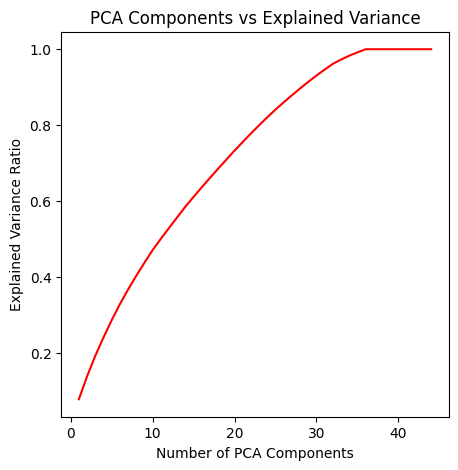

                                       model  var
n                                                
44  PCA(n_components=44, random_state=15020) 1.00
43  PCA(n_components=43, random_state=15020) 1.00
42  PCA(n_components=42, random_state=15020) 1.00
41  PCA(n_components=41, random_state=15020) 1.00
40  PCA(n_components=40, random_state=15020) 1.00
36  PCA(n_components=36, random_state=15020) 1.00
39  PCA(n_components=39, random_state=15020) 1.00
38  PCA(n_components=38, random_state=15020) 1.00
37  PCA(n_components=37, random_state=15020) 1.00
35  PCA(n_components=35, random_state=15020) 0.99
34  PCA(n_components=34, random_state=15020) 0.98
33  PCA(n_components=33, random_state=15020) 0.97
32  PCA(n_components=32, random_state=15020) 0.96
31  PCA(n_components=31, random_state=15020) 0.95
30  PCA(n_components=30, random_state=15020) 0.93
29  PCA(n_components=29, random_state=15020) 0.91
28  PCA(n_components=28, random_state=15020) 0.90
27  PCA(n_components=27, random_state=15020) 0.88


In [21]:
# Convert list to DataFrame for analysis
# Hide columns for PCA
# For performance reasons
# When you need to visualize 2-3 dimensions


pca_df = pd.concat(pca_list, axis=1).T.set_index('n')

# Plot the explained variance
plt.figure(figsize=(5, 5))
sns.lineplot(x=pca_df.index, y='var', data=pca_df, color='red')
plt.xlabel('Number of PCA Components')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA Components vs Explained Variance')
plt.show()

# Display the top PCA components sorted by variance
print(pca_df.sort_values(by='var', ascending=False).head(30))

As discussed, let us keep all the features since the dataset is not huge, PCA is often a choice based on data complexity rather than a strict rule.

In [22]:
# Keep all features using PCA
PCAmod = PCA(n_components=44, random_state=random_seed)
PCAmod.fit(X_scaled_subscribers)
PCA_df = pd.DataFrame(PCAmod.transform(X_scaled_subscribers))

# Now we will need to determine the optimal number of numbers to use for our K-Means
# algorithm

**K-Means:** As mentioned previously, this works by randomly selecting k centroids
and each data point is assigned to nearest centroid using Euclidean distance.
The centroids of clusters are then recalculated by finding the mean of data points assigned to each cluster. This process is repeated until the centroids stop changing.

The goal of this algorithm is to minimize inertia or within-cluster sum of squares (how compact clusters are). The lower the inertia, the better the clusters will be well separated.


**The Elbow Method:**

Technique used to determine the optimal number of clusters in K-Means by evaluating how many additional clusters improve quality of the model.

We run K-Means of several clusters, calculating inertia for each value of k. We plot Interia Vs K and look for the "elbow point" where adding clusters after that point no longer significantly reduces inertia (i.e., diminishing returns). The rate of decrease of inertia slows down after a certain point and after that point, the improvement is minimal.

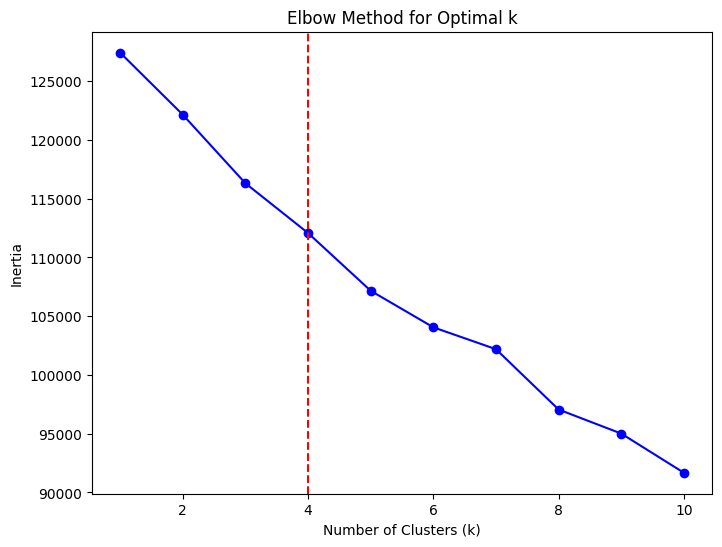

In [22]:
# Let us run K-Means for several k-values & look for the elbow point
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

# Create an elbow plot to find the optimal number of clusters
def elbow_method(data, max_clusters=10):
    inertia = []
    for k in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=random_seed)
        kmeans.fit(data)
        inertia.append(kmeans.inertia_)  # Inertia = within-cluster sum of squares

    # Plotting the elbow plot
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, max_clusters + 1), inertia, marker='o', color='blue')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for Optimal k')
    plt.axvline(x=4, linestyle='--', color='r')  # Optional: Red line for the optimal k
    plt.show()

# Example of usage
elbow_method(PCA_df, max_clusters=10)

The elbow method clearly shows that k=3 is a distinct point where afterwards we get diminishing returns for the rate of change of inertia.

We will now run the K-Means algorithnm on our data to get cluster labels.

In [23]:
# Select k = 3 & run the K-Means algorithm
# Function to run KMeans clustering
def K_Means(n_clusters, data):
    k_means = KMeans(n_clusters=n_clusters, random_state=random_seed)
    k_means.fit(data)

    # Predict cluster labels for the data
    cluster_labels = k_means.predict(data)
    return cluster_labels


n_clusters = 3
cluster_labels = K_Means(n_clusters, PCA_df)

PCA_df_clustered = PCA_df.copy()
# Assign cluster labels to the original data
PCA_df_clustered['cluster'] = cluster_labels


### Silhouette Score


Another important metric is the Silhouette Score to see how well the data is clustered. It calculates how similar a data point is to its given cluster.

The score ranges from -1 to 1 where 1 is well matched, 0 is close to the decision boundary between 2 clusters & -1 means the data point has been assigned to a wrong cluster.

Formula:

s(i) = (b(i) - a(i)) / (max(a(i), b(i)))

Where a(i) stands for Cohesion, average distance to all other data points within the same cluster

& b(i) stands for Separation, average distance from point i to points in the nearest neighboring cluster.


Now, the higher the average score (closer it is to 1), the better our clustering.

In [24]:
from sklearn.metrics import silhouette_score

# Silhouette Score (optional, evaluates how well clusters are separated)
silhouette_avg = silhouette_score(PCA_df_clustered, cluster_labels)
print(f"For {3} clusters, the silhouette score is: {silhouette_avg:.4f}")

For 3 clusters, the silhouette score is: 0.0809


Unfortunately, we get a really low Silhouette Score of 0.0809, indicating that the clustering is not well-defined & that the data points may not fit well within their assigned clusters. A near zero score suggests clusters are either overalapping or poorly separated.

Our elbow method did not work in this case, let us experiment with other cluster numbers to see if we can get a silhouette score

In [25]:
for k in range(2, 20):
    kmeans = KMeans(n_clusters=k, random_state=random_seed)
    cluster_labels = kmeans.fit_predict(PCA_df)
    silhouette_avg = silhouette_score(PCA_df, cluster_labels)
    print(f"For {k} clusters, the silhouette score is: {silhouette_avg:.4f}")


For 2 clusters, the silhouette score is: 0.1052
For 3 clusters, the silhouette score is: 0.0749
For 4 clusters, the silhouette score is: 0.0743
For 5 clusters, the silhouette score is: 0.0676
For 6 clusters, the silhouette score is: 0.0760
For 7 clusters, the silhouette score is: 0.0782
For 8 clusters, the silhouette score is: 0.0930
For 9 clusters, the silhouette score is: 0.0954
For 10 clusters, the silhouette score is: 0.0994
For 11 clusters, the silhouette score is: 0.1011
For 12 clusters, the silhouette score is: 0.1113
For 13 clusters, the silhouette score is: 0.1122
For 14 clusters, the silhouette score is: 0.1149
For 15 clusters, the silhouette score is: 0.1195
For 16 clusters, the silhouette score is: 0.1176
For 17 clusters, the silhouette score is: 0.1290
For 18 clusters, the silhouette score is: 0.1373
For 19 clusters, the silhouette score is: 0.1302


Lower Scores for Small k: The silhouette scores for k = 2 to k = 8 are very low (around 0.10 to 0.13), which indicates poor clustering. The data points are not well-separated or cohesive within their clusters for these smaller numbers of clusters.

Cluster Quality: The low silhouette scores suggest that KMeans is not able to find well-defined clusters in our data. The data may not have distinct, natural groupings, or the feature space may not be well-suited for KMeans clustering.

We can explore alternative clustering algorithms (e.g., DBSCAN, Agglomerative Clustering) and reconsider the use of PCA to see if we can improve the clustering results. This we can do as further work to achieve better defined clusters.

Our elbow method relied on inertia score, but it seems 2 clusters has the highest silhouette score between 2-5 clusters. We will select 2 clusters and as mentioned previously, add the cluster column to our original dataset and see if we can spot any obvious differences between the type of customers in the dataset.

In [26]:
# Select k = 2 & run the K-Means algorithm based on silhouttee score
n_clusters = 2
cluster_labels = K_Means(n_clusters, PCA_df)

PCA_df_clustered = PCA_df.copy()
# Assign cluster labels to the original data
PCA_df_clustered['cluster'] = cluster_labels


In [27]:
# Step 1: Add the cluster labels to the original dataframe
original_layer_3_data['cluster'] = PCA_df_clustered['cluster']

In [28]:
original_layer_3_data['cluster'].value_counts()

,count
cluster,
1,2381
0,515


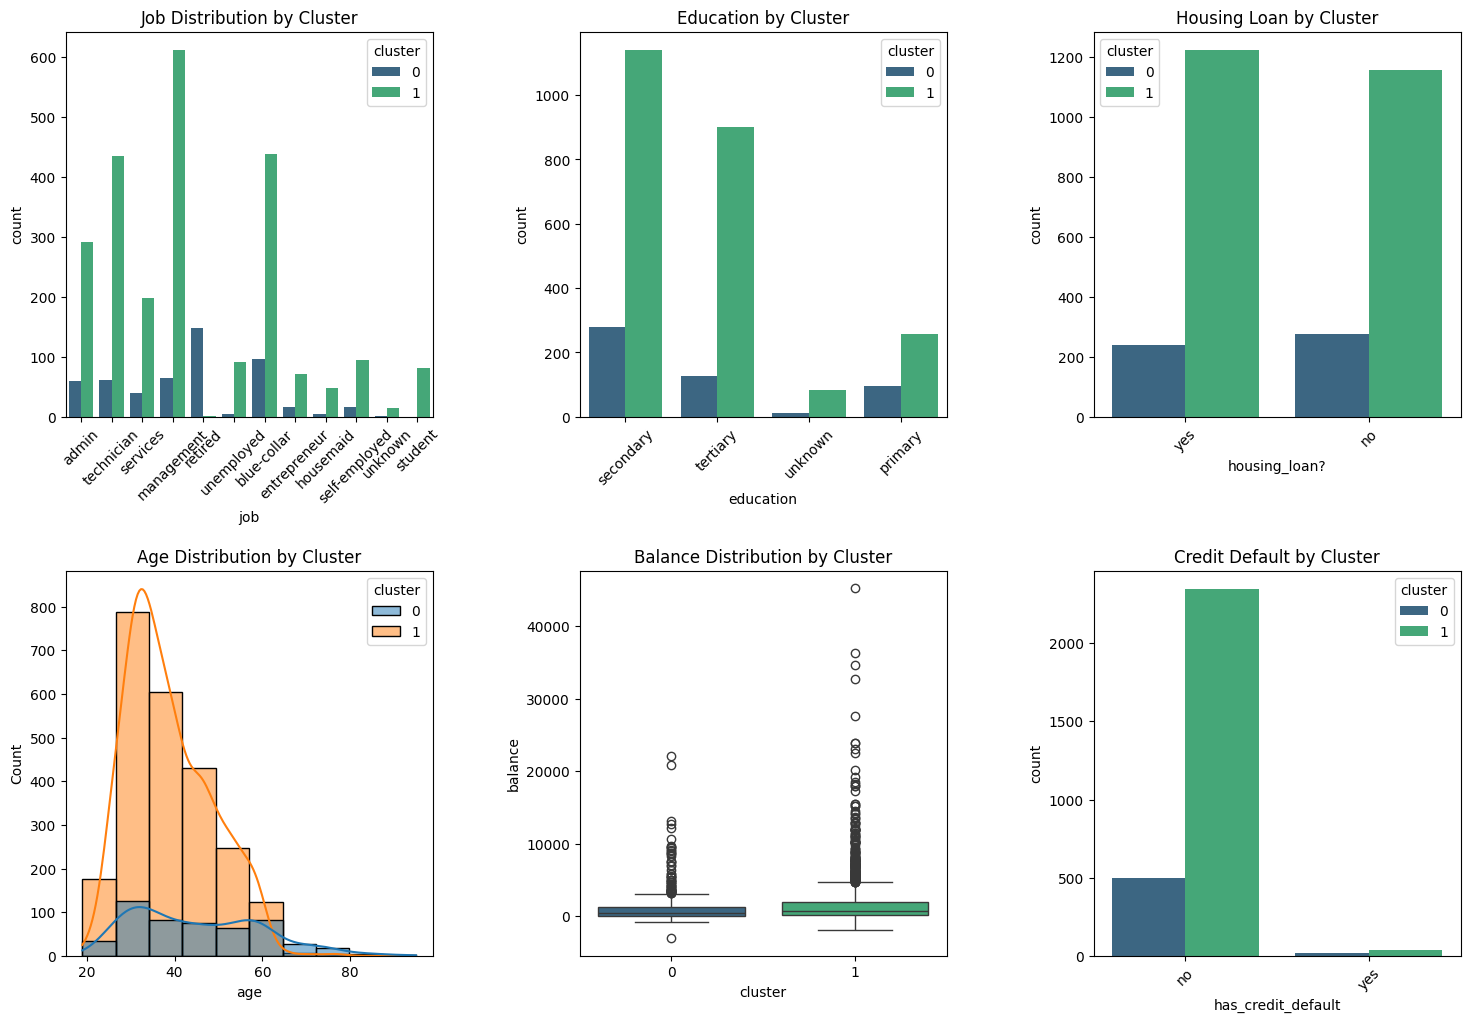

In [29]:
# Visualize the clusters separation in different columns such as age, job type etc
# analyze the distribution of clusters

import matplotlib.pyplot as plt
import seaborn as sns

# Set up a 3x3 grid for the subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Adjust layout for better readability
plt.subplots_adjust(hspace=0.4, wspace=0.4)

# Visualization 1: Job distribution with hue='cluster'
sns.countplot(data=original_layer_3_data, x='job', palette='viridis', hue='cluster', ax=axes[0, 0])
axes[0, 0].set_title('Job Distribution by Cluster')
axes[0, 0].tick_params(axis='x', rotation=45)

# Visualization 2: Education distribution with hue='cluster'
sns.countplot(data=original_layer_3_data, x='education', palette='viridis', hue='cluster', ax=axes[0, 1])
axes[0, 1].set_title('Education by Cluster')
axes[0, 1].tick_params(axis='x', rotation=45)

# Visualization 3: Housing loan distribution with hue='cluster'
sns.countplot(data=original_layer_3_data, x='housing_loan?', palette='viridis', hue='cluster', ax=axes[0, 2])
axes[0, 2].set_title('Housing Loan by Cluster')
axes[0, 2].tick_params(axis='x', rotation=45)

# Visualization 4: Age distribution with hue='cluster'
sns.histplot(data=original_layer_3_data, x='age', bins=10, kde=True, hue='cluster', ax=axes[1, 0])
axes[1, 0].set_title('Age Distribution by Cluster')

# Visualization 5: Balance distribution with hue='cluster'
sns.boxplot(data=original_layer_3_data, x='cluster', y='balance', palette='viridis', ax=axes[1, 1])
axes[1, 1].set_title('Balance Distribution by Cluster')

# Visualization 6: Credit default with hue='cluster'
sns.countplot(data=original_layer_3_data, x='has_credit_default', palette='viridis', hue='cluster', ax=axes[1, 2])
axes[1, 2].set_title('Credit Default by Cluster')
axes[1, 2].tick_params(axis='x', rotation=45)



# Display the visualizations
plt.show()


Based on the above visualization, it is difficult to clearly identify a customer segment but one that notably stands out is those customers who have higher yearly balance overall and are part of managerial level roles but it seems the clustering has not really separated them out, we require further number of clusters.

In [30]:
# Let us also see summary statistics for both clusters

# Filter for cluster 1
cluster_1_data = original_layer_3_data[original_layer_3_data['cluster'] == 1]

# Filter for cluster 0
cluster_0_data = original_layer_3_data[original_layer_3_data['cluster'] == 0]

# Get descriptive statistics for cluster 1 (for object columns)
cluster_1_description = cluster_1_data.describe(include='object')
cluster_1_description_numerical = cluster_1_data.describe()

# Get descriptive statistics for cluster 0 (for object columns)
cluster_0_description = cluster_0_data.describe(include='object')
cluster_0_description_numerical = cluster_0_data.describe()


In [31]:
print(cluster_1_description)
cluster_1_description_numerical

               job  marital  education has_credit_default housing_loan?  \
count         2381     2381       2381               2381          2381   
unique          12        3          4                  2             2   
top     management  married  secondary                 no           yes   
freq           612     1186       1140               2347          1224   

       personal_loan communication_type last_contacted_month  \
count           2381               2381                 2381   
unique             1                  3                   10   
top               no           cellular                  may   
freq            2381               1847                  666   

       client_subscribed?  
count                2381  
unique                  1  
top                   yes  
freq                 2381  


,age,balance,last_contacted_day,contact_duration,number_of_contacts_in_campaign,cluster
count,2381.00,2381.00,2381.00,2381.00,2381.00,2381.00
mean,38.68,1675.74,15.81,671.96,2.43,1.00
std,9.66,3018.89,8.70,425.79,2.34,0.00
min,19.00,-1944.00,1.00,8.00,1.00,1.00
25%,31.00,165.00,8.00,347.00,1.00,1.00
50%,37.00,674.00,16.00,615.00,2.00,1.00
75%,46.00,1988.00,22.00,898.00,3.00,1.00
max,78.00,45248.00,31.00,3881.00,32.00,1.00


In [32]:
print(cluster_0_description)
cluster_0_description_numerical

            job  marital  education has_credit_default housing_loan?  \
count       515      515        515                515           515   
unique       11        3          4                  2             2   
top     retired  married  secondary                 no            no   
freq        149      292        278                500           275   

       personal_loan communication_type last_contacted_month  \
count            515                515                  515   
unique             2                  3                   11   
top              yes           cellular                  jul   
freq             380                386                  128   

       client_subscribed?  
count                 515  
unique                  1  
top                   yes  
freq                  515  


,age,balance,last_contacted_day,contact_duration,number_of_contacts_in_campaign,cluster
count,515.00,515.00,515.00,515.00,515.00,515.00
mean,45.22,1185.12,15.92,733.83,2.35,0.00
std,14.64,2405.52,7.90,452.82,2.16,0.00
min,21.00,-3058.00,1.00,11.00,1.00,0.00
25%,32.00,25.50,9.00,420.50,1.00,0.00
50%,43.00,397.00,16.00,677.00,2.00,0.00
75%,57.00,1263.50,21.00,984.50,3.00,0.00
max,95.00,22125.00,31.00,3253.00,24.00,0.00


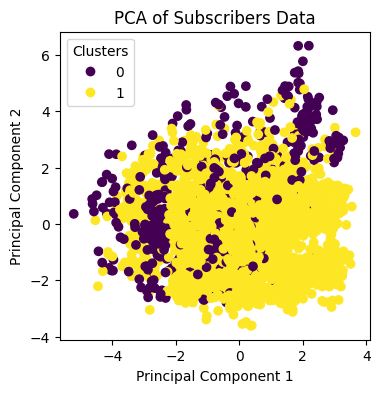

In [33]:
# Let us PCA to see the relationship between the two clusters - reduce columns to 2 features only

pca = PCA(n_components=2, random_state=random_seed)
principal_components = pca.fit_transform(X_scaled_subscribers)
PCA_testing_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# Select k = 2 & run the K-Means algorithm based on silhouttee score
n_clusters = 2
cluster_labels = K_Means(n_clusters, X_scaled_subscribers)

# Assign cluster labels to the original data
PCA_testing_df['cluster'] = cluster_labels


plt.figure(figsize=(4,4))
scatter = plt.scatter(PCA_testing_df['PC1'], PCA_testing_df['PC2'], c=PCA_testing_df['cluster'], cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Subscribers Data')
plt.legend(*scatter.legend_elements(), title='Clusters')
plt.show()


It seems from the above results that two major customer segments would be:

1. Customers who are in management level roles & have previous housing loan.
2. Customers who are retired and have do not have a previous housing loan.

With regards to the age, it seems both of the clusters have the same average age, only that there are a lot more data points in cluster 1 than in cluster 0.

In [34]:
# It seems there is not much distinction between the two clusters, let us try with 3 clusters with K-Means
# based on inertia score
# Assume we found k=4 from the elbow method
n_clusters = 3
cluster_labels = K_Means(n_clusters, PCA_df)

PCA_df_clustered = PCA_df.copy()
# Assign cluster labels to the original data
PCA_df_clustered['cluster'] = cluster_labels

# Step 1: Add the cluster labels to the original dataframe
original_layer_3_data['cluster'] = PCA_df_clustered['cluster']

original_layer_3_data['cluster'].value_counts()


,count
cluster,
1,1425
2,1318
0,153


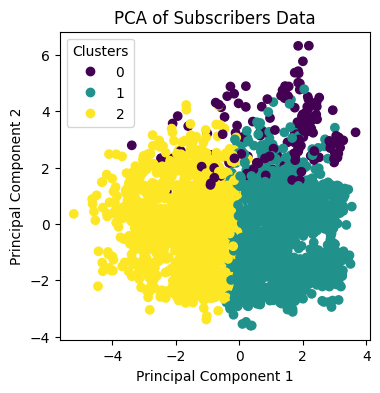

In [35]:
# Let us PCA to see the relationship between the three clusters - reduce columns to 3 features only

pca = PCA(n_components=2, random_state=random_seed)
principal_components = pca.fit_transform(X_scaled_subscribers)
PCA_testing_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# Select k = 2 & run the K-Means algorithm based on silhouttee score
n_clusters = 3
cluster_labels = K_Means(n_clusters, X_scaled_subscribers)

# Assign cluster labels to the original data
PCA_testing_df['cluster'] = cluster_labels


plt.figure(figsize=(4,4))
scatter = plt.scatter(PCA_testing_df['PC1'], PCA_testing_df['PC2'], c=PCA_testing_df['cluster'], cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Subscribers Data')
plt.legend(*scatter.legend_elements(), title='Clusters')
plt.show()


As we see above, when it came to 2 clusters, the clustering visualizing was poor however with 3 clusters, it suggests that clustering method and number of clusters has likely captured most of the underlying structure in the data.

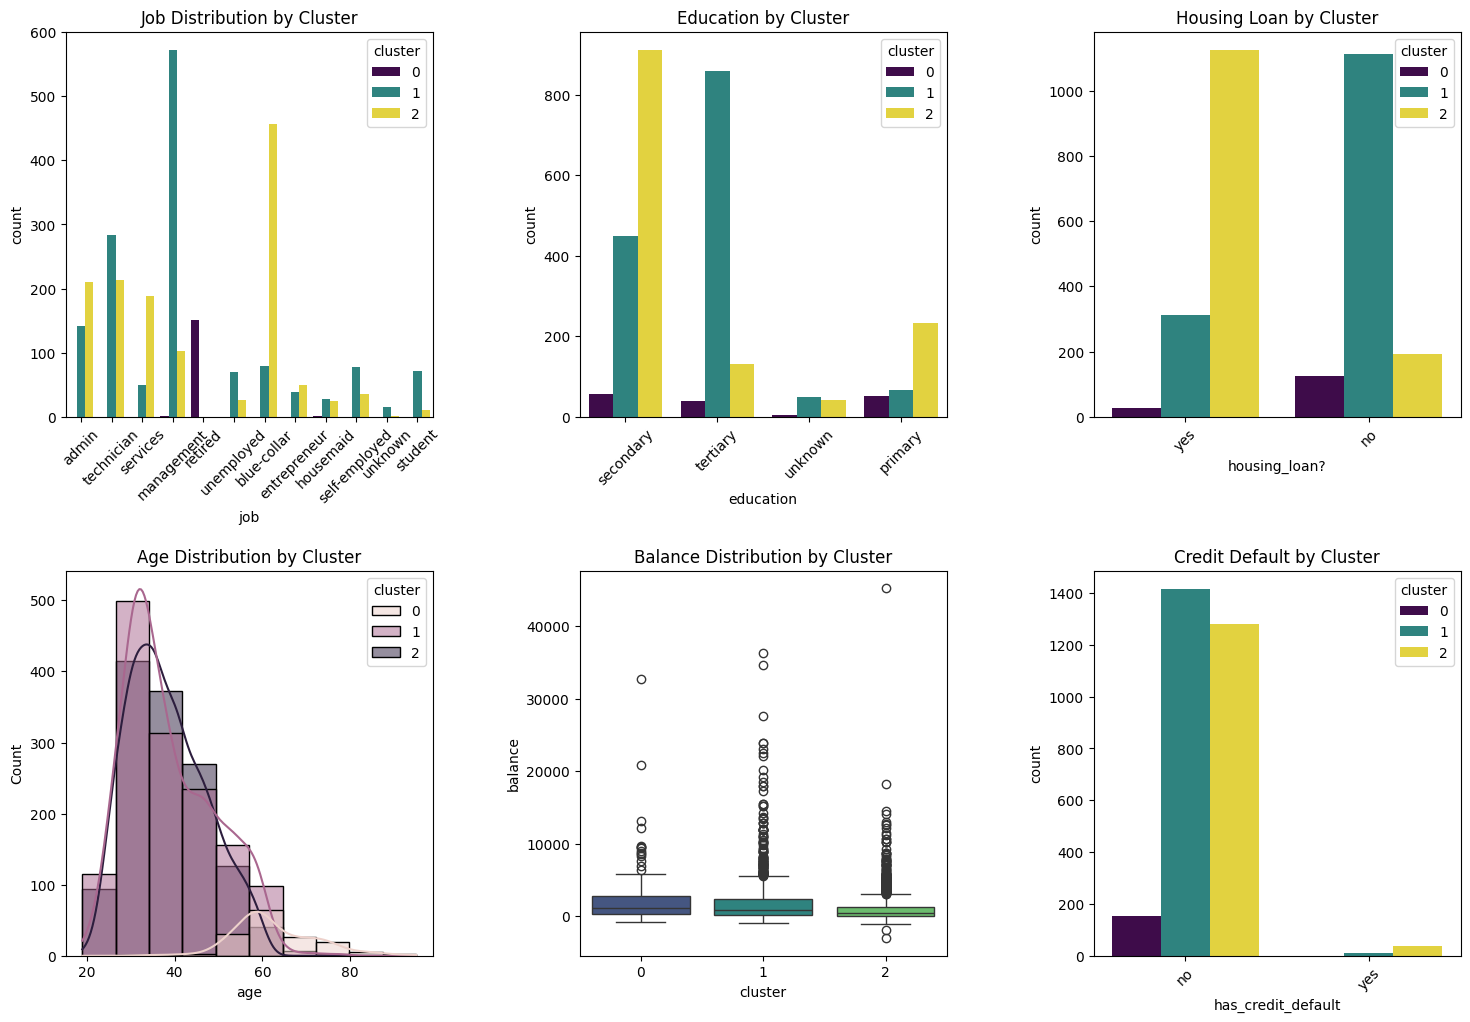

In [36]:
# Visualize the clusters separation in different columns such as age, job type etc
# analyze the distribution of clusters

import matplotlib.pyplot as plt
import seaborn as sns

# Set up a 3x3 grid for the subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Adjust layout for better readability
plt.subplots_adjust(hspace=0.4, wspace=0.4)

# Visualization 1: Job distribution with hue='cluster'
sns.countplot(data=original_layer_3_data, x='job', palette='viridis', hue='cluster', ax=axes[0, 0])
axes[0, 0].set_title('Job Distribution by Cluster')
axes[0, 0].tick_params(axis='x', rotation=45)

# Visualization 2: Education distribution with hue='cluster'
sns.countplot(data=original_layer_3_data, x='education', palette='viridis', hue='cluster', ax=axes[0, 1])
axes[0, 1].set_title('Education by Cluster')
axes[0, 1].tick_params(axis='x', rotation=45)

# Visualization 3: Housing loan distribution with hue='cluster'
sns.countplot(data=original_layer_3_data, x='housing_loan?', palette='viridis', hue='cluster', ax=axes[0, 2])
axes[0, 2].set_title('Housing Loan by Cluster')
axes[0, 2].tick_params(axis='x', rotation=45)

# Visualization 4: Age distribution with hue='cluster'
sns.histplot(data=original_layer_3_data, x='age', bins=10, kde=True, hue='cluster', ax=axes[1, 0])
axes[1, 0].set_title('Age Distribution by Cluster')

# Visualization 5: Balance distribution with hue='cluster'
sns.boxplot(data=original_layer_3_data, x='cluster', y='balance', palette='viridis', ax=axes[1, 1])
axes[1, 1].set_title('Balance Distribution by Cluster')

# Visualization 6: Credit default with hue='cluster'
sns.countplot(data=original_layer_3_data, x='has_credit_default', palette='viridis', hue='cluster', ax=axes[1, 2])
axes[1, 2].set_title('Credit Default by Cluster')
axes[1, 2].tick_params(axis='x', rotation=45)



# Display the visualizations
# Change the PCA
plt.show()


## Remarks:

Segmenting our customers into additional clusters using K-Means has provided some valuable insights. Notably, Cluster 2 and Cluster 1 stand out where Cluster 1 predominantly consisting of individuals in managerial roles, with no prior credit default, and holding tertiary education.


Cluster 2 on the other hand primarily consists of people with secondary education, and blue collar jobs.

However, beyond this, it is challenging to identify distinct, meaningful segments within our subscriber base.

Next Steps:
K-Means has shown limited effectiveness in clearly segmenting our subscribers. To achieve more meaningful clustering, we will need to explore alternative algorithms and metrics, such as DBSCAN, Gaussian Mixture Models (GMM), and Hierarchical Agglomerative Clustering (HAC), using metrics like distortion for evaluation.

### Experimentation with TSNE & UMAP

What is UMAP?

Uniform Manifold Approximation and Projection (UMAP) is a dimensionality reduction technique, it is popular for its effectiveness in maintaining the local & global structure of data. Non-linear dimensionality reduction technique based on concepts from topology and manifold learning. It models the data as a graph where points are connected based on their similarity and attempts to maintain this stucture when projected to lower dimensions.

Unlike PCA, UMAP is a non-linear dimensionality reduction, and maintains both local and global structures. Applicable to various data types (numerical, categorical, mixed), less interpretable due to non-linear transformations


In [37]:
pip install umap-learn


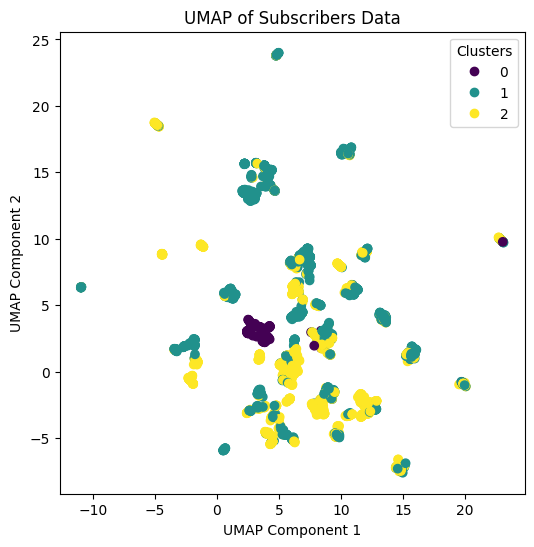

In [38]:
from umap import UMAP  # Correct import

# Step 1: Apply UMAP to reduce to 2 dimensions
umap_model = UMAP(n_components=2, random_state=random_seed)
umap_components = umap_model.fit_transform(X_scaled_subscribers)
UMAP_testing_df = pd.DataFrame(data=umap_components, columns=['UMAP1', 'UMAP2'])

# Step 2: Select k = 3 & run the K-Means algorithm based on silhouette score
n_clusters = 3
cluster_labels = KMeans(n_clusters=n_clusters, random_state=random_seed).fit_predict(X_scaled_subscribers)

# Step 3: Assign cluster labels to the UMAP-transformed data
UMAP_testing_df['cluster'] = cluster_labels

# Step 4: Plot the clusters based on UMAP components
plt.figure(figsize=(6, 6))
scatter = plt.scatter(UMAP_testing_df['UMAP1'], UMAP_testing_df['UMAP2'], c=UMAP_testing_df['cluster'], cmap='viridis')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.title('UMAP of Subscribers Data')
plt.legend(*scatter.legend_elements(), title='Clusters')
plt.show()


What is t-SNE?

t-Distributed Stochastic Neighbor Embedding (t-SNE) is a non-linear dimensionality reduction technique as well, particularly effective for visualizing high dimensional data by mapping to a lower-dimensional space. t-SNE excels at revealing patterns & clusters in complex datasets making it a valuable tool for EDA.

This technique uses Gaussian distribution to compute similarity between pairs of data points and iteratively adjusts points in low-dimensional space to minimize the divergence between the pairwise similarities in high-dimensional space and those in low-dimensional space. Minimize Kullback-Leibler divergence between two distributions. t-SNE is limited generally to smaller datasets like the one we have.


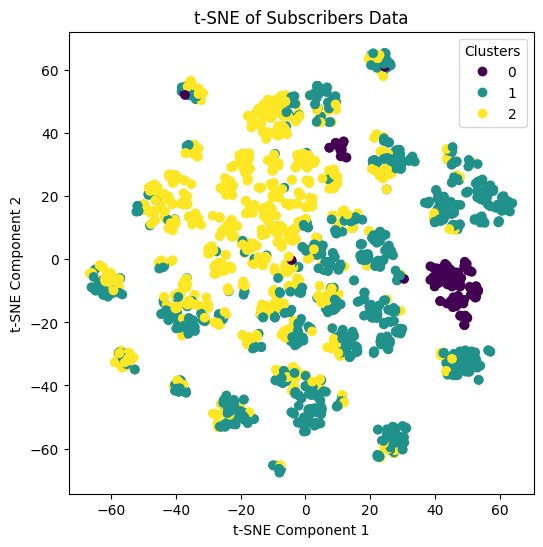

In [39]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Apply t-SNE to reduce to 2 dimensions
tsne_model = TSNE(n_components=2, random_state=random_seed)
tsne_components = tsne_model.fit_transform(X_scaled_subscribers)
TSNE_testing_df = pd.DataFrame(data=tsne_components, columns=['TSNE1', 'TSNE2'])

# Step 2: Select k = 3 & run the K-Means algorithm based on silhouette score
n_clusters = 3
cluster_labels = KMeans(n_clusters=n_clusters, random_state=random_seed).fit_predict(X_scaled_subscribers)

# Step 3: Assign cluster labels to the t-SNE transformed data
TSNE_testing_df['cluster'] = cluster_labels

# Step 4: Plot the clusters based on t-SNE components
plt.figure(figsize=(6, 6))
scatter = plt.scatter(TSNE_testing_df['TSNE1'], TSNE_testing_df['TSNE2'], c=TSNE_testing_df['cluster'], cmap='viridis')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE of Subscribers Data')
plt.legend(*scatter.legend_elements(), title='Clusters')
plt.show()


### HAC (Hierarchical Agglomerative Clustering)

- It is a clustering algorithm grouping similar points based on similarity or distance. This takes a "bottom-up" approach where each data point initially is treated as an individual cluster & these are merged based on a distance metric. This process continues until all points merge into one cluster.

- We see this output in a tree-like structure called a **Dendogram**.

Dendograms are a way to visually inspect the data hierarchy and determine the optimal number of clusters for Hierarchical Agglomerative Clustering (HAC). By analyzing the dendrogram, you can identify the number of clusters by cutting the dendrogram at an appropriate height where there is a significant jump in distance (large vertical lines between merged clusters).

In [40]:
!pip install yellowbrick

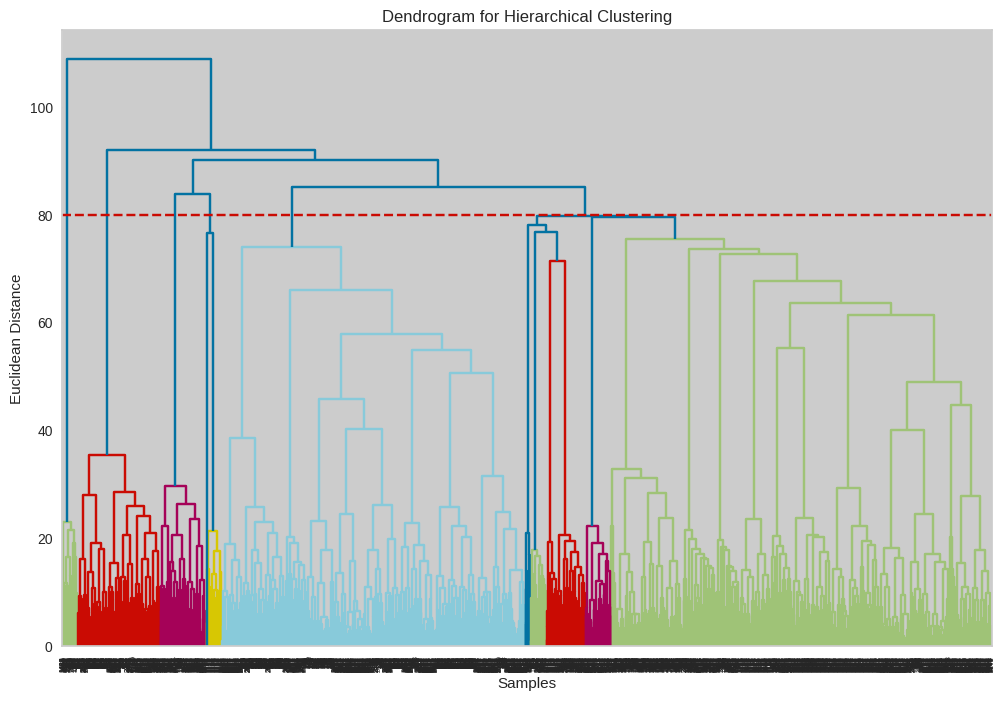

In [46]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Step 1: Create the linkage matrix
linkage_matrix = linkage(X_scaled_subscribers, method='ward')  # 'ward' minimizes variance in the clusters

# Step 2: Plot the dendrogram
plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix)
plt.title("Dendrogram for Hierarchical Clustering")
plt.xlabel("Samples")
plt.ylabel("Euclidean Distance")
# Add a dotted horizontal line to indicate a threshold
threshold = 80  # Choose a distance threshold
plt.axhline(y=threshold, color='r', linestyle='--', label=f"Threshold = {threshold}")
plt.show()

It seems based on dendogram that 4-6 clusters seem optimal, let us go with 6 clusters for now and examine further.

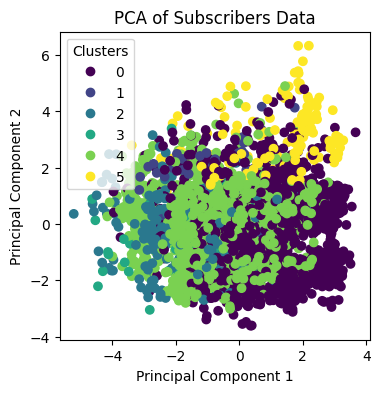

In [23]:
from sklearn.cluster import AgglomerativeClustering

n_clusters = 6  # Choose the number of clusters
hac = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='ward')
cluster_labels = hac.fit_predict(PCA_df)

PCA_df_clustered = PCA_df.copy()
# Assign cluster labels to the original data
PCA_df_clustered['cluster'] = cluster_labels


pca = PCA(n_components=2, random_state=random_seed)
principal_components = pca.fit_transform(X_scaled_subscribers)
PCA_testing_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])


# Assign cluster labels to the original data
PCA_testing_df['cluster'] = cluster_labels


plt.figure(figsize=(4,4))
scatter = plt.scatter(PCA_testing_df['PC1'], PCA_testing_df['PC2'], c=PCA_testing_df['cluster'], cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Subscribers Data')
plt.legend(*scatter.legend_elements(), title='Clusters')
plt.show()


Let us also experiment with 3 clusters as well to see if more visible clusters are formed:





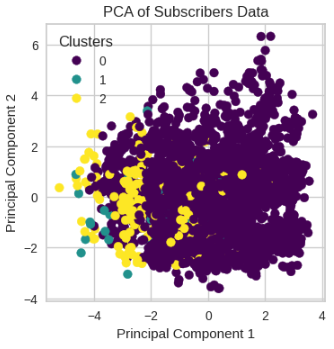


Let us do the some further EDA based on our clusters formed by HAC with the current features

In [24]:
# Step 1: Add the cluster labels to the original dataframe
original_layer_3_data['cluster'] = PCA_df_clustered['cluster']

original_layer_3_data['cluster'].value_counts()

,count
cluster,
0,1454
4,944
2,257
5,143
3,49
1,49


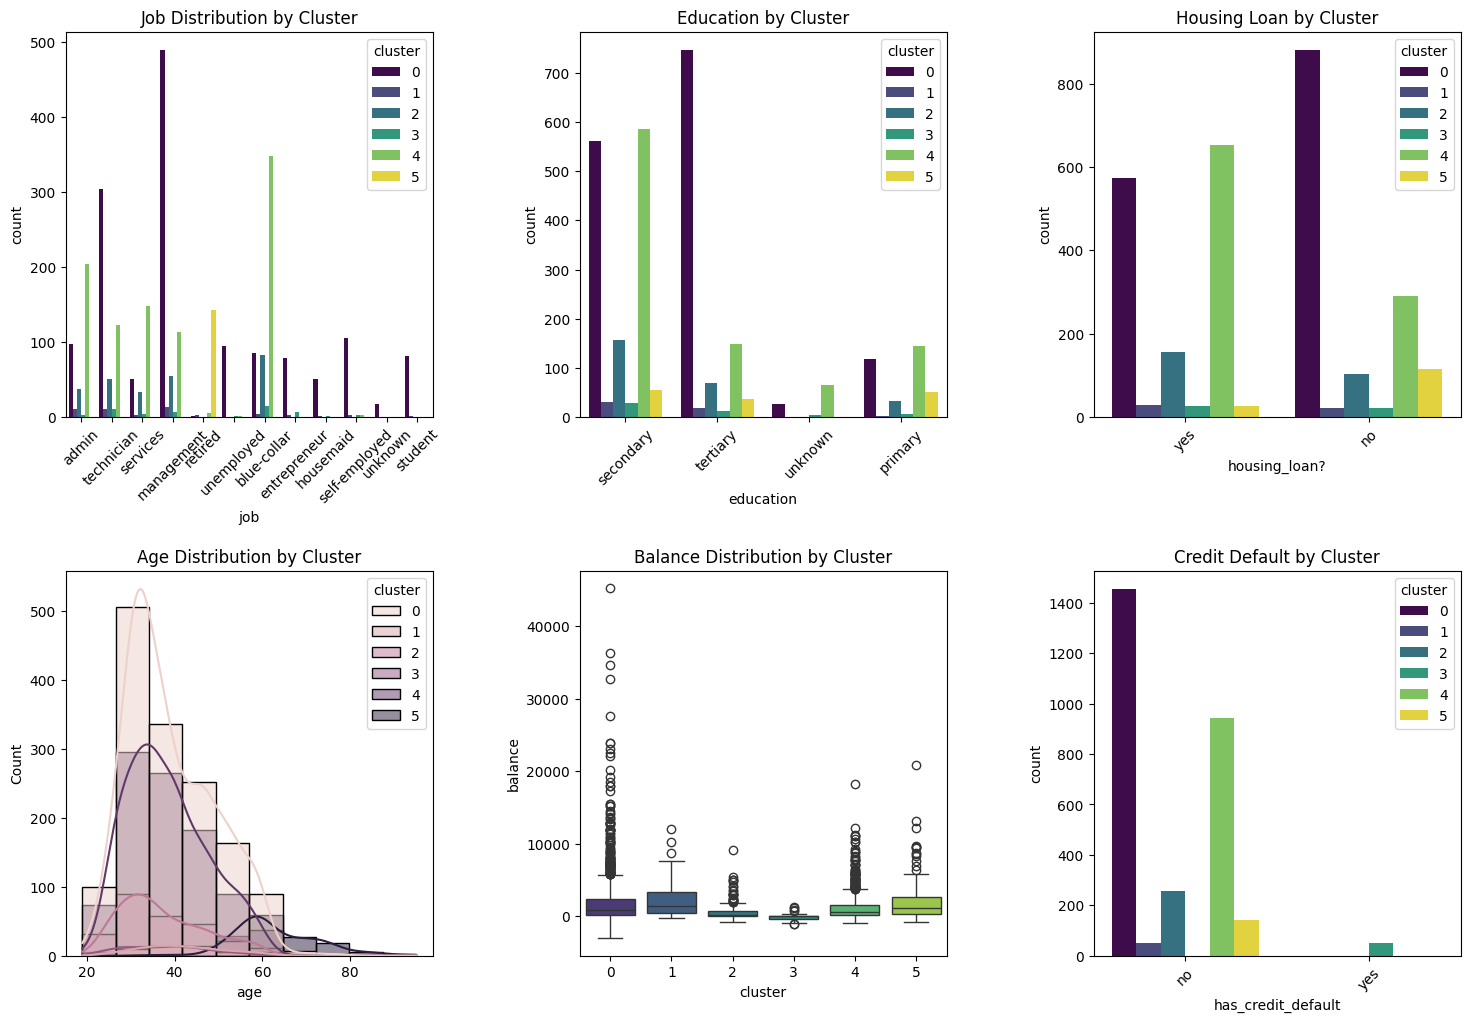

In [25]:
# Visualize the clusters separation in different columns such as age, job type etc
# analyze the distribution of clusters

import matplotlib.pyplot as plt
import seaborn as sns

# Set up a 3x3 grid for the subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Adjust layout for better readability
plt.subplots_adjust(hspace=0.4, wspace=0.4)

# Visualization 1: Job distribution with hue='cluster'
sns.countplot(data=original_layer_3_data, x='job', palette='viridis', hue='cluster', ax=axes[0, 0])
axes[0, 0].set_title('Job Distribution by Cluster')
axes[0, 0].tick_params(axis='x', rotation=45)

# Visualization 2: Education distribution with hue='cluster'
sns.countplot(data=original_layer_3_data, x='education', palette='viridis', hue='cluster', ax=axes[0, 1])
axes[0, 1].set_title('Education by Cluster')
axes[0, 1].tick_params(axis='x', rotation=45)

# Visualization 3: Housing loan distribution with hue='cluster'
sns.countplot(data=original_layer_3_data, x='housing_loan?', palette='viridis', hue='cluster', ax=axes[0, 2])
axes[0, 2].set_title('Housing Loan by Cluster')
axes[0, 2].tick_params(axis='x', rotation=45)

# Visualization 4: Age distribution with hue='cluster'
sns.histplot(data=original_layer_3_data, x='age', bins=10, kde=True, hue='cluster', ax=axes[1, 0])
axes[1, 0].set_title('Age Distribution by Cluster')

# Visualization 5: Balance distribution with hue='cluster'
sns.boxplot(data=original_layer_3_data, x='cluster', y='balance', palette='viridis', ax=axes[1, 1])
axes[1, 1].set_title('Balance Distribution by Cluster')

# Visualization 6: Credit default with hue='cluster'
sns.countplot(data=original_layer_3_data, x='has_credit_default', palette='viridis', hue='cluster', ax=axes[1, 2])
axes[1, 2].set_title('Credit Default by Cluster')
axes[1, 2].tick_params(axis='x', rotation=45)



# Display the visualizations
# Change the PCA
plt.show()


Let us see some descriptive statistics for the first three clusters as we see cluster 0 and cluster 4 have the almost the same type of distribution of customer types. It seems the yellow cluster (cluster 5) is the one full of retired individuals and not having previous credit default.

In [30]:
# Filter for cluster 1
cluster_1_data = original_layer_3_data[original_layer_3_data['cluster'] == 1]

# Filter for cluster 0
cluster_0_data = original_layer_3_data[original_layer_3_data['cluster'] == 0]

# Filter for cluster 2
cluster_2_data = original_layer_3_data[original_layer_3_data['cluster'] == 2]

# Filter for cluster 3
cluster_5_data = original_layer_3_data[original_layer_3_data['cluster'] == 5]

# Get descriptive statistics for cluster 1 (for object columns)
cluster_0_description_numerical = cluster_0_data.describe()
cluster_1_description_numerical = cluster_1_data.describe()
cluster_2_description_numerical = cluster_2_data.describe()
cluster_5_description_numerical = cluster_5_data.describe()


In [32]:
descriptive_statistics = [cluster_0_description_numerical, cluster_1_description_numerical, cluster_2_description_numerical, cluster_5_description_numerical]

for i in range(4):
  if i == 3:
    print(f'cluster_{5}_description_numerical')
    print(descriptive_statistics[i])
  else:
    print(f'cluster_{i}_description_numerical')
    print(descriptive_statistics[i])

cluster_0_description_numerical
          age  balance  last_contacted_day  contact_duration  \
count 1454.00  1454.00             1454.00           1454.00   
mean    39.02  1987.96               15.92            646.61   
std      9.99  3574.74                8.78            436.20   
min     19.00 -3058.00                1.00              8.00   
25%     31.00   201.00                8.00            305.25   
50%     37.00   801.50               16.50            577.00   
75%     46.00  2417.75               22.00            883.50   
max     78.00 45248.00               31.00           3102.00   

       number_of_contacts_in_campaign  cluster  
count                         1454.00  1454.00  
mean                             2.53     0.00  
std                              2.55     0.00  
min                              1.00     0.00  
25%                              1.00     0.00  
50%                              2.00     0.00  
75%                              3.00     0.00  

In [34]:
# Let us see some more statistics for cluster 5, the retired class

cluster_5_data.describe(include='object')

,job,marital,education,has_credit_default,housing_loan?,personal_loan,communication_type,last_contacted_month,client_subscribed?
count,143,143,143,143,143,143,143,143,143
unique,1,3,3,1,2,2,3,8,1
top,retired,married,secondary,no,no,no,cellular,apr,yes
freq,143,93,55,143,116,129,100,36,143


The identified cluster comprises primarily retired individuals who are generally married, possess a secondary education, have no history of credit default, and predominantly use mobile or cellular communication. This cluster represents a significant target demographic, as it is the most prevalent group within cluster 5 of our subscribers.

### Results Interpretation

Even with Agglomerative clustering, we do not see much improved and distinguised clustering results. We can see in all clusters that mean age is around 40 whereas in cluster 5, it is 63 which shows cluster 5 comprises more of older ages, mainly retired individuals

## Summary & Future Work

**Layer 1:** Subscriber Identification

Using a Bernoulli Naive Bayes model with a recall score of 62% for subscribers (class 1), our model effectively identifies a significant portion of potential subscribers from the dataset. This enables the startup to optimize its operations by reducing call volume significantly. Instead of calling all 40,000 customers, the model recommends focusing on 18,849 customers, saving approximately 1,500 hours of call time.

**Layer 2: **Refining Subscriber Predictions

To improve the precision and recall balance, we developed a second model focused on selecting high-confidence potential subscribers from the subset identified in Layer 1. Here, XGBoost provided the best performance with the following metrics for the subscriber class:

1. Recall: 78%
2. Precision: 48%
3. F1 Score: 59%
4. F2 Score (β=2): 69% (emphasizing recall).

This balance ensures the model identifies a large number of subscribers without overlooking too many potential customers while maintaining reasonable confidence in its predictions. Additionally, the non-subscriber precision was 98%, allowing the client to confidently exclude customers identified as non-subscribers, further optimizing resource allocation.

**Layer 3:** Customer Segmentation

In the final layer, we employed clustering techniques like K-Means and Hierarchical Agglomerative Clustering (HAC) to segment subscribers and uncover common characteristics. Dimensionality reduction and metrics like the elbow method, silhouette score, and inertia score helped determine the optimal number of clusters.

Key findings include:

K-Means Results:

* Cluster 1: Predominantly managerial-level individuals with tertiary education and no prior credit defaults.
* Cluster 2: Composed of individuals with secondary education, blue-collar jobs, and more variability in their credit history.


HAC Results:

* A unique cluster was identified, consisting primarily of retired individuals who are generally married, possess secondary education, have no credit defaults, and primarily use mobile communication. This segment represented the most prominent group in cluster 5, making it a significant target demographic.
These insights highlight distinct customer segments, such as managerial-level individuals with high yearly balances and retired individuals with different financial behaviors. However, further refinement of clusters may provide deeper insights.

Future Work
To enhance the model and segmentation:

*  Alternative Clustering Methods: Experiment with algorithms like DBSCAN or Gaussian Mixture Models (GMM) to improve cluster separation and discover more nuanced customer segments.

*  Enhanced Dimensionality Reduction: Explore advanced techniques for dimensionality reduction to improve clustering performance.

*  Integration of Insights: Combine insights from all layers to refine customer targeting strategies

Conclusion

The results of our analysis demonstrate significant time and resource savings for the client by leveraging predictive modeling and clustering. By integrating insights from Layers 1 and 2 with the segmentation findings from Layer 3, the client can focus their efforts on high-value customer segments, increasing efficiency and effectiveness in targeting potential subscribers.